In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
sns.set_style({'font.family':"sans-serif"})
sns.set_style('darkgrid')

**Methods and definitions.**

In [3]:
def my_pie(data, group, title, ax=None, figsize=None):
    data.groupby([group]).size().plot.pie(
        title=title, 
        ylabel='', 
        autopct=lambda p:'{:.1f}% ({:.0f})'.format(p, (p/100)*data.groupby([group]).size().sum()),
        figsize=figsize,
        ax=ax
    )

def my_bar(data, group, title, ax=None, figsize=None):
    ax_t = data.groupby([group]).size().plot.bar(
        title=title, 
        ylabel='count', 
        figsize=figsize,
        ax=ax
    )
    ax_t.bar_label(ax_t.containers[0])

def my_hist_with_qq(data, column, title, xlabel, figsize=(15, 6)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    data[column].plot.hist(title=title, ax=ax1)
    ax1.set_xlabel(xlabel)
    
    with mpl.rc_context():
        mpl.rc("figure", figsize=(3,3))
        sm.qqplot(data[column], line ='45', fit=True, ax=ax2)

def my_count(data, column, title, ax=None, order=None):
    fig, ax_t = plt.subplots()
    ax_t = sns.countplot(
        y = column, 
        data = data, 
        order = order, 
        ax=ax,
        palette='deep'
    )
    ax_t.bar_label(ax_t.containers[0])
    ax_t.set_title(title)

def my_box(data, columns, title, xlabel='count', ax=None, figsize=None):
    fig, ax_t = plt.subplots(figsize=figsize)
    ax_t = sns.boxplot(
        data=data[[x for x in data.columns if x in columns]],
        orient='h',
        ax=ax,
        palette='deep'
    ).set(xlabel=xlabel, title=title)

def my_box_xy(data, x, y, title, xlabel='count', ax=None, order=None):
    if(not ax):
        fig, ax_t = plt.subplots()
    sns.boxplot(
        data=data,
        orient='h',
        ax=ax,
        x=x,
        y=y,
        palette='deep',
        order=order
    ).set(xlabel=xlabel, title=title)
    
def my_dist(data, x, hue, title):
    sns.displot(
        data=data, 
        x=x, 
        hue=hue, 
        kind="kde",
    ).set(title=title)
    
def my_test(test, data, column, group, title):
    print(title)
    cols = [data[data[group] == x][column] for x in data[group].unique()]
    stat = test(*cols)
    print("{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))

    if(stat.pvalue < 0.05 and test == stats.kruskal):
        p_vals = []

        for comb in list(combinations(cols, 2)):
            stat = stats.mannwhitneyu(*comb)
            p_vals.append(stat.pvalue)

        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(data[group].unique(), 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')
        

def my_chi(data, group1, group2, merge_index=False, merge_cols=False):
    counts = data.groupby([group1, group2]).size().unstack().fillna(0)
    
    if(merge_index):
        for index in merge_index:
            for index2 in merge_index[index]:
                counts.loc[index] = counts.loc[index] + counts.loc[index2]
                counts = counts.drop(axis=0, index=[index2])
        
    if(merge_cols):
        for col in merge_cols:
            for col2 in merge_cols[col]:
                counts.loc[:, col] = counts.loc[:, col] + counts.loc[:, col2]
                counts = counts.drop(axis=1, columns=[col2])
                
    print(counts, end='\n\n')
    
    stat, p, d, exp = stats.chi2_contingency(counts)
    print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
    print('expected frequencies:')
    print(exp, end='\n\n')
    
    if(p < 0.05):
        p_vals = []

        for comb in list(combinations(counts.columns, 2)):
            new_df = counts[[comb[0], comb[1]]]
            chi2, p, dof, ex = stats.chi2_contingency(new_df)
            p_vals.append(p)
        with np.errstate(divide='ignore'):
            reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(counts.columns, 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')

def my_bar_grouped(data, column, group, title, hue_order=None, ax=None):
    plt.figure(tight_layout=True)
    ax_t = sns.barplot(
        data=data.groupby([column, group]).size().reset_index(), 
        y=0, 
        x=column, 
        hue=group,
        palette='deep',
        linewidth=2,
        hue_order = hue_order,
        ax=ax
    ).set(title=title, xlabel=column, ylabel='count')

def my_mean_plot(data, columns, group, title, label_x=None, label_y=None, order=None):
    if(not order):
        data.groupby([group]).mean().reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    else:
        data.groupby([group]).mean().loc[order].reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
def my_heatmap(data, columns):
    corr = data[columns].corr(method='spearman')
    sns.heatmap(corr, annot=True)
    
def multiple_tests(test, columns, labels):
    p_vals = []

    for comb in list(combinations(columns, 2)):
        stat = test(*comb)
        p_vals.append(stat.pvalue)

    if(test == stats.kruskal or test == stats.mannwhitneyu):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    if(test == stats.chi2_contingency):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

    print('Post-hoc testing:')
    print(list(combinations(labels, 2)))
    print(corrected_p_vals)
    print(reject_list, end='\n\n\n')
    
def my_test2(test, followup_test, columns, title, labels):
    print(title)
    stat = test(*columns)
    for i in range(len(columns)):
        print(labels[i] + ' mean: ' + str(columns[i].mean()))
        print(labels[i] + ' std: ' + str(columns[i].std()))
    print("\n{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))
    
    if(stat.pvalue < 0.05 and len(columns) > 2):
        multiple_tests(stats.mannwhitneyu, columns, labels)
    

attrak = {
    'PQ1': 'complicated - simple', 
    'PQ2': 'impractical - practical', 
    'PQ3': 'unpredictable - predictable', 
    'PQ4': 'confusing - clearly constructed', 
    'HQ1': 'tacky - stylish', 
    'HQ2': 'cheap - premium', 
    'HQ3': 'unimaginative - creative', 
    'HQ4': 'dull - captivating', 
    'ATT1': 'ugly - attractive', 
    'ATT2': 'bad - good',
    'PQ': 'All pragmatic qualities',
    'HQ': 'All hedonic qualities',
    'ATT': 'All attractiveness qualities'
}

open_text = {
    'company': 'Company\'s name',
    'purpose': 'Company\'s purpose',
    'purpose_token_count': 'Number of full meaning words in purpose',
    'purpose_word_count': 'Number of words in purpose question',
    'detail': 'Website\'s detail',
    'desc_eval_comp': 'Description complexity',
    'desc_eval_elem': 'Number of identified elements in description',
    'desc_eval_char': 'Number of identified characterists in description',
    'desc_eval_sum': 'Sum of identified characteristics and elements in description',
    'desc_token_count': 'Number of full meaning words in description',
    'desc_word_count': 'Number of words in description'
}

# Cognitive tasks analysis

**Load data and merge**

In [4]:
results = pd.read_csv("../data/results.csv", index_col=0)
respondents = pd.read_csv("../data/respondents.csv", index_col=0)

In [5]:
respondents = respondents[respondents.status=='completed']

In [6]:
data = results.merge(respondents[
    ['respondent', 'interval', 'time_taken', 
     'vmt_levels', 'vmt_levels_group',
     'vmt_click_speed', 'vmt_click_speed_group', 
     'vmt_press_len', 'vmt_press_len_group',
     'pst_levels', 'pst_levels_group',
     'pst_levels_correct', 'pst_levels_correct_group',
     'pst_mistakes', 'pst_mistakes_group',
     'pst_press_speed', 
     'age', 'gender', 'education', 'web_browsing', 'web_skill']
], on=['respondent', 'interval'], how='outer')

In [7]:
fixed_data = data[(data.interval != '2s') | (data.interval == '2s') & (data.respondent != 50)]

**Heatmaps**

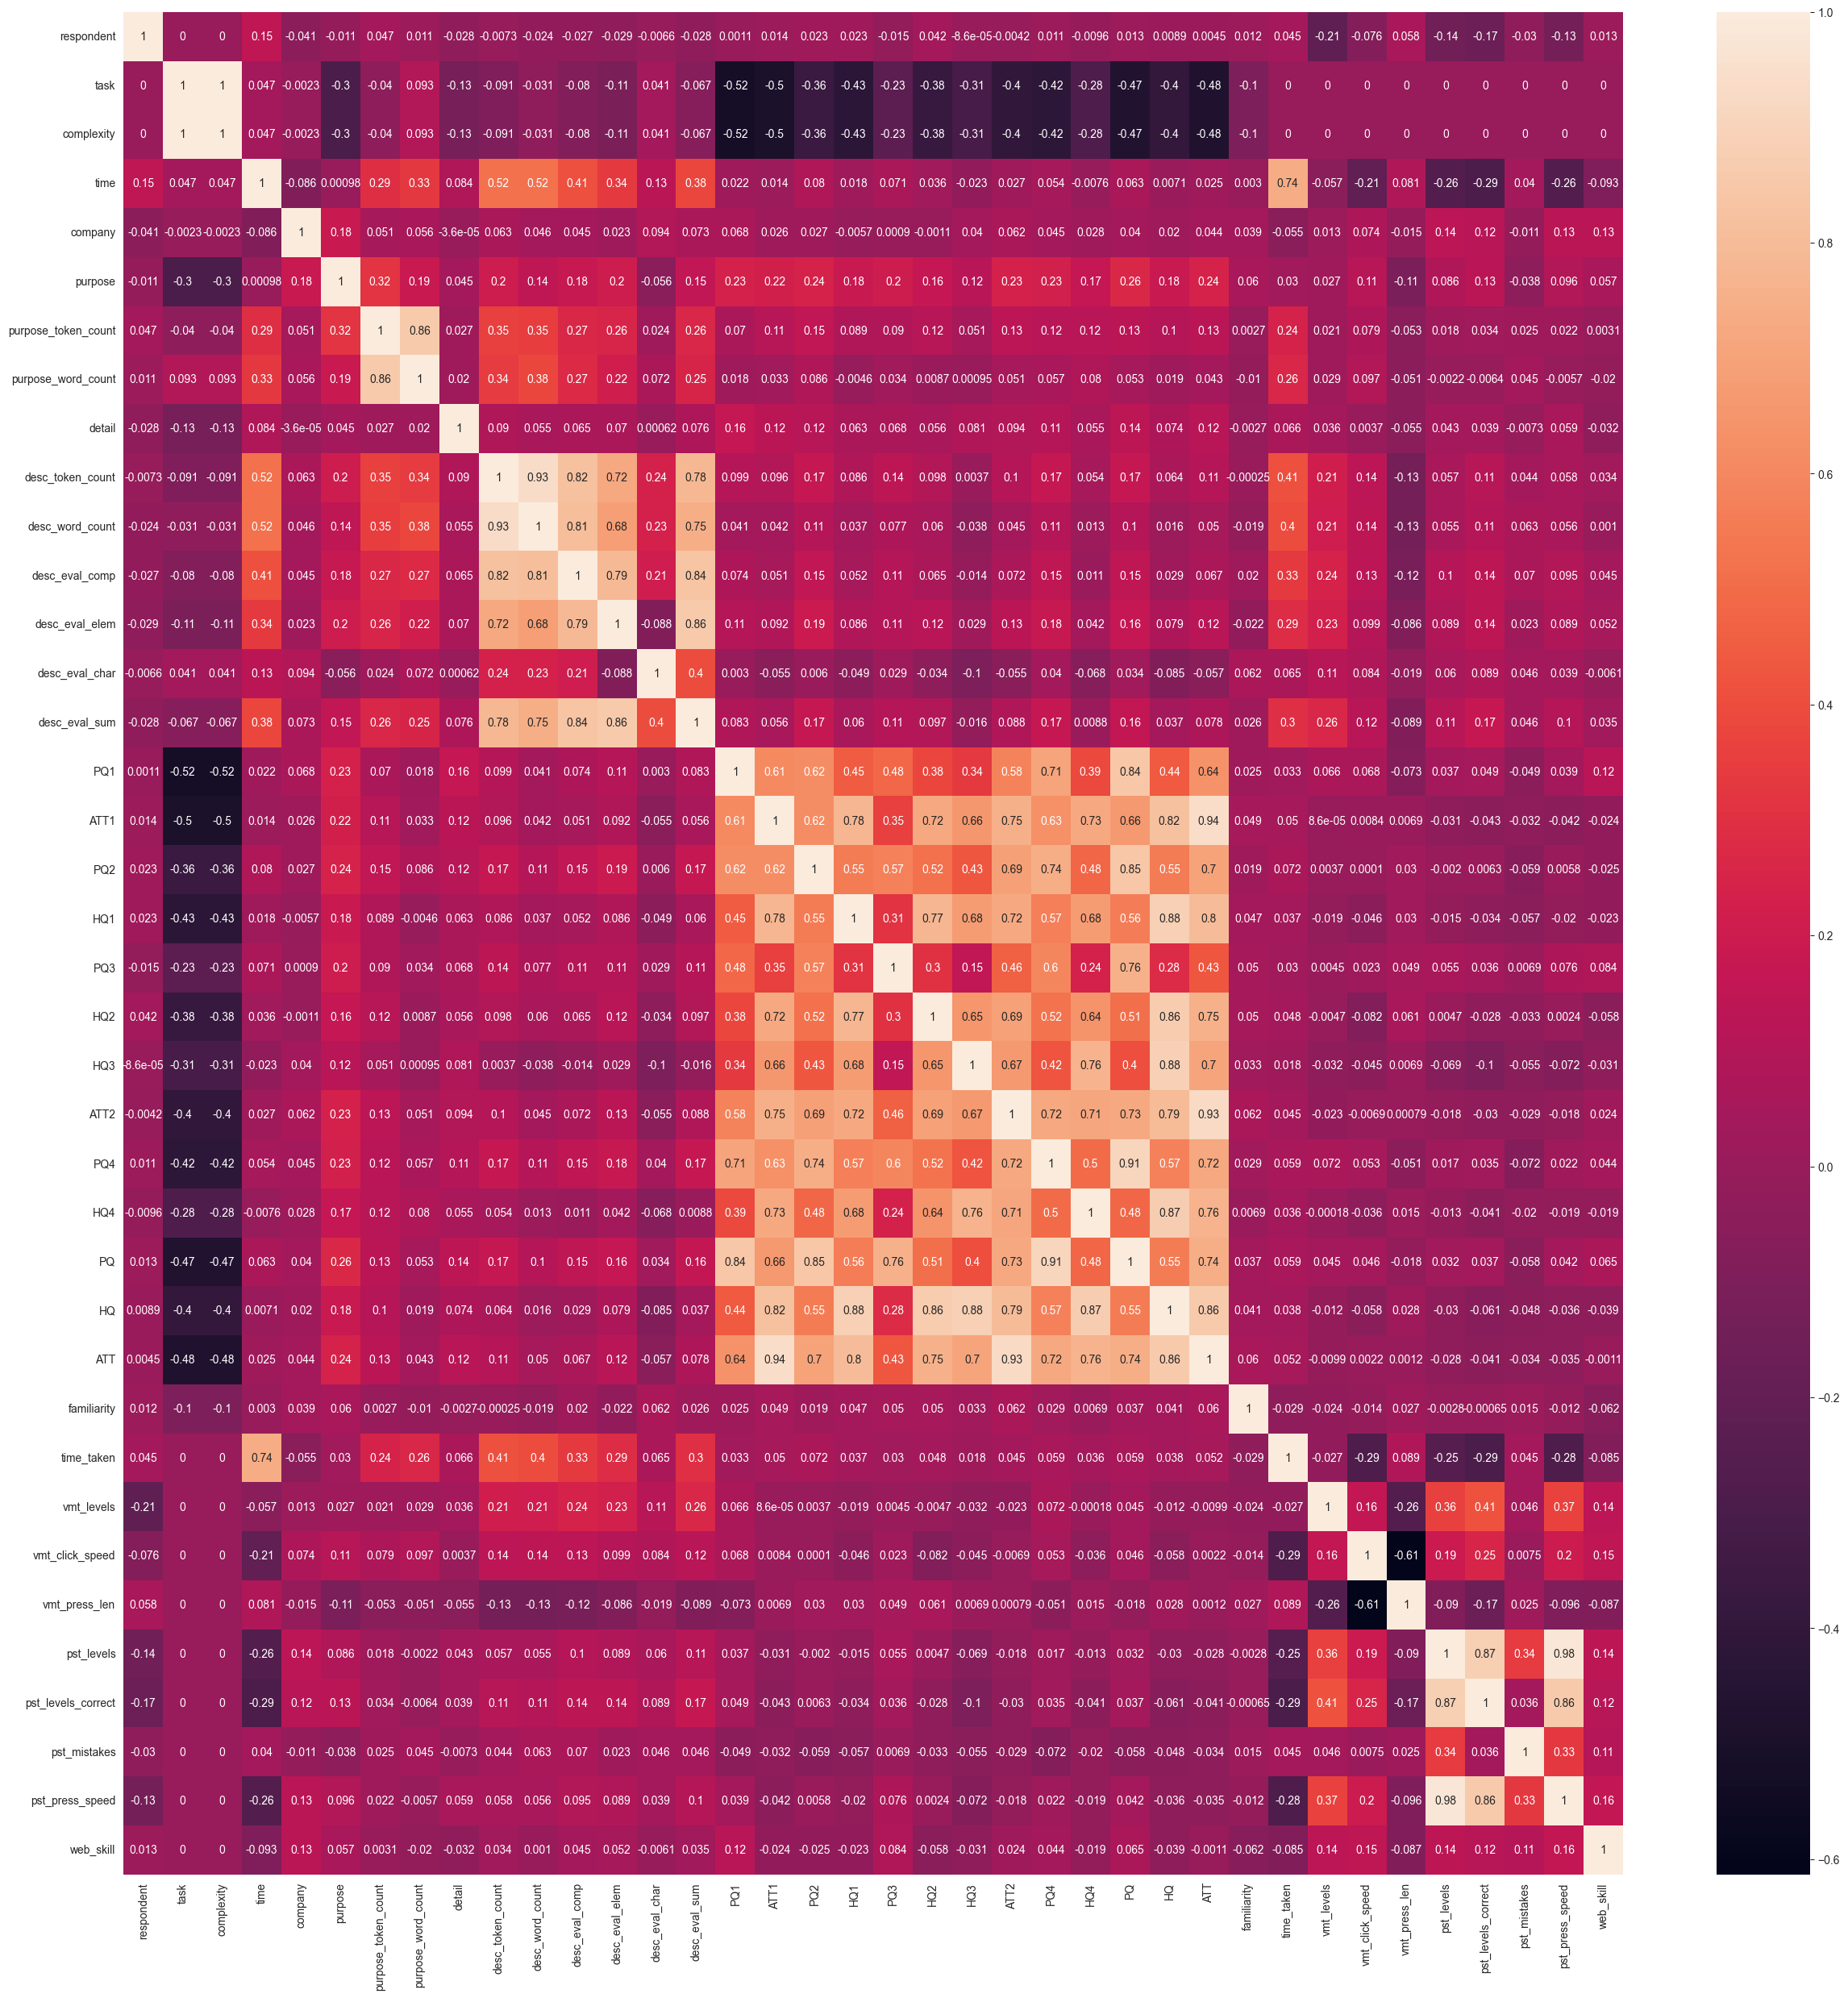

In [8]:
fig, ax = plt.subplots(figsize=(30, 30))
my_heatmap(data, data.columns)

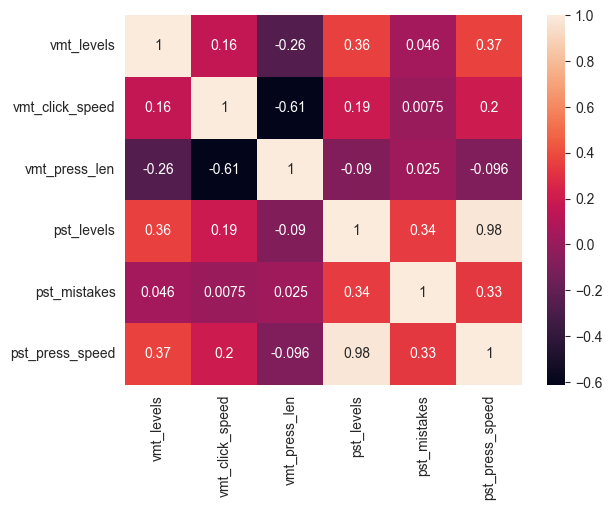

In [9]:
my_heatmap(data, ['vmt_levels', 'vmt_click_speed', 'vmt_press_len', 'pst_levels', 'pst_mistakes', 'pst_press_speed'])

## VMT achieved level

In [10]:
data[['task'] + list(attrak.keys()) + ['vmt_levels_group']].groupby(['vmt_levels_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
vmt_levels_group                                                           
low                3.5  4.522989  5.028736  4.810345  4.614943  4.350575   
med                3.5  4.557377  4.893443  4.775956  4.765027  4.308743   
high               3.5  4.805556  5.116667  4.827778  4.961111  4.294444   

                       HQ2       HQ3       HQ4      ATT1      ATT2        PQ  \
vmt_levels_group                                                               
low               4.206897  4.051724  4.091954  4.402299  4.735632  4.744253   
med               4.005464  3.770492  3.980874  4.360656  4.491803  4.747951   
high              4.150000  3.927778  4.133333  4.433333  4.622222  4.927778   

                        HQ       ATT  
vmt_levels_group                      
low               4.175287  4.568966  
med               4.016393  4.426230  
high              4.126389  4.527778

In [11]:
data[['task'] + list(open_text.keys()) + ['vmt_levels_group']].groupby(['vmt_levels_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
vmt_levels_group                                                  
low                3.5  0.916667  0.824713             2.637931   
med                3.5  0.933060  0.830601             2.513661   
high               3.5  0.930556  0.894444             2.888889   

                  purpose_word_count    detail  desc_eval_comp  \
vmt_levels_group                                                 
low                         4.137931  0.264368        0.695402   
med                         3.989071  0.265027        0.833333   
high                        4.655556  0.313889        1.333333   

                  desc_eval_elem  desc_eval_char  desc_eval_sum  \
vmt_levels_group                                                  
low                     1.293103        0.379310       1.672414   
med                     1.412568        0.423497       1.836066   
high                    2.033333        0.566667       2.600000   

                  desc_token_count  desc_word_count  
vmt_levels_group                                     
low                       8.218391        17.275862  
med                       9.215847        18.991803  
high                     12.833333        29.661111

In [12]:
data[['task'] + list(attrak.keys()) + ['vmt_levels_group']].groupby(['vmt_levels_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
vmt_levels_group                                                               
low               1.712754  1.782069  1.552280  1.459950  1.739047  1.396972   
med               1.710163  1.506420  1.306301  1.236021  1.498668  1.223191   
high              1.712589  1.561038  1.317162  1.254403  1.514783  1.339963   

                       HQ2       HQ3       HQ4      ATT1      ATT2        PQ  \
vmt_levels_group                                                               
low               1.415341  1.536708  1.490875  1.651482  1.458162  1.412157   
med               1.271381  1.276469  1.270170  1.361298  1.260002  1.195380   
high              1.339036  1.281717  1.359428  1.553874  1.354304  1.184304   

                        HQ       ATT  
vmt_levels_group                      
low               1.294226  1.464754  
med               1.117913  1.227547  
high              1.161984  1.367747

In [13]:
data[['task'] + list(open_text.keys()) + ['vmt_levels_group']].groupby(['vmt_levels_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
vmt_levels_group                                                      
low               1.712754  0.263828  0.367807             1.747318   
med               1.710163  0.237625  0.345211             1.939801   
high              1.712589  0.228939  0.279609             1.812091   

                  purpose_word_count    detail  desc_eval_comp  \
vmt_levels_group                                                 
low                         3.616508  0.432355        0.771068   
med                         4.864734  0.437278        0.770755   
high                        4.017173  0.457802        1.013870   

                  desc_eval_elem  desc_eval_char  desc_eval_sum  \
vmt_levels_group                                                  
low                     1.132932        0.593634       1.163828   
med                     1.083756        0.656595       1.198360   
high                    1.311317        0.717693       1.443924   

                  desc_token_count  desc_word_count  
vmt_levels_group                                     
low                       5.094313        11.325647  
med                       6.059510        13.858678  
high                      7.719597        21.011613

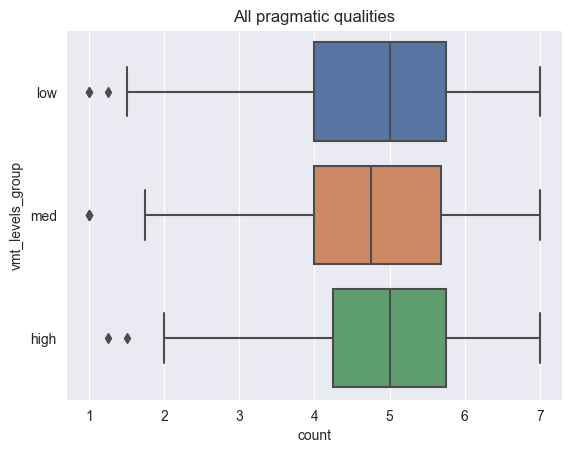

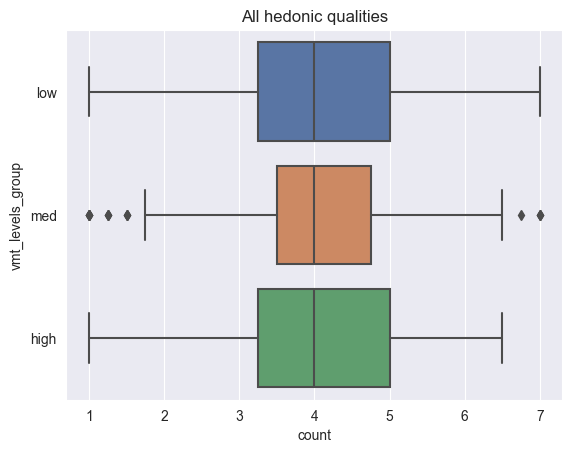

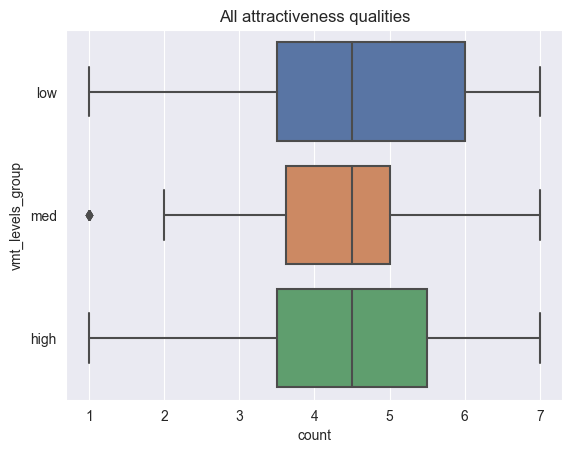

In [14]:
for column in ['PQ', 'HQ', 'ATT']:
    my_box_xy(data, column, 'vmt_levels_group', attrak[column], order=['low', 'med', 'high'])

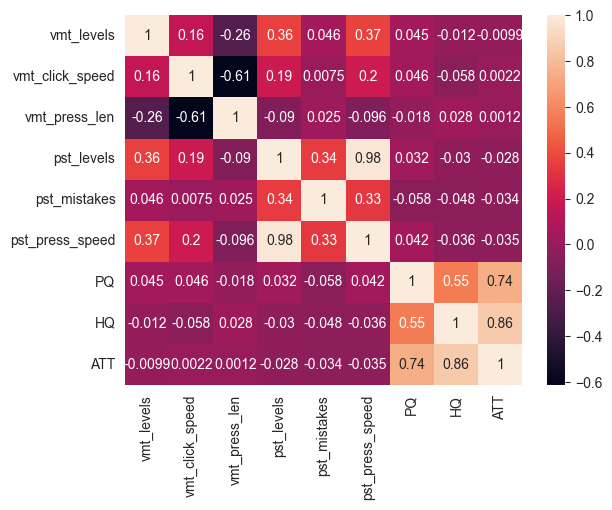

In [15]:
my_heatmap(data, ['vmt_levels', 'vmt_click_speed', 'vmt_press_len', 'pst_levels', 'pst_mistakes', 'pst_press_speed', 'PQ', 'HQ', 'ATT'])

In [16]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'vmt_levels_group', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.23048625602764855

HQ (All hedonic qualities)
 pvalue: 0.47085134291231945

ATT (All attractiveness qualities)
 pvalue: 0.4057466392805211



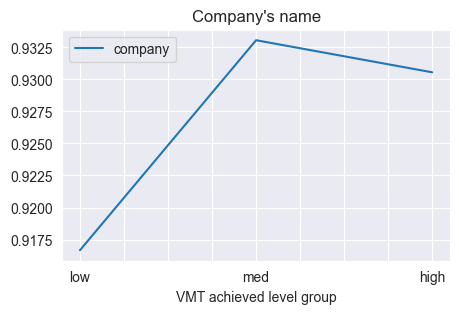

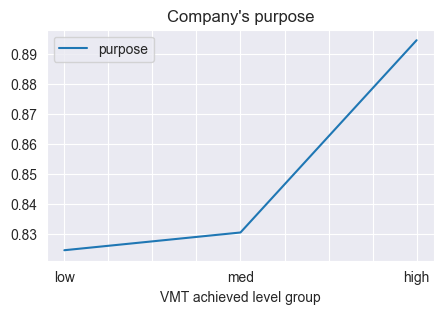

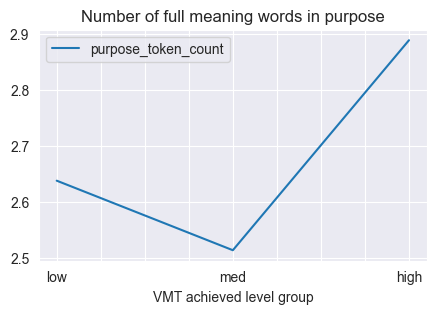

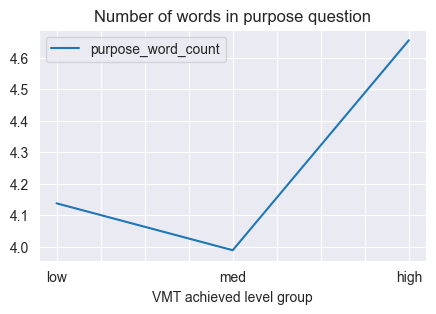

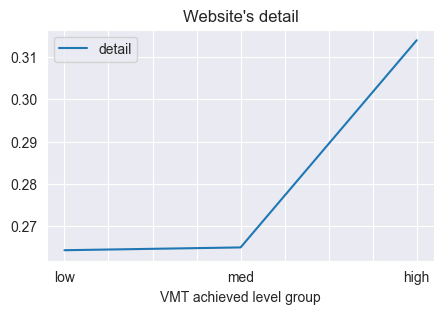

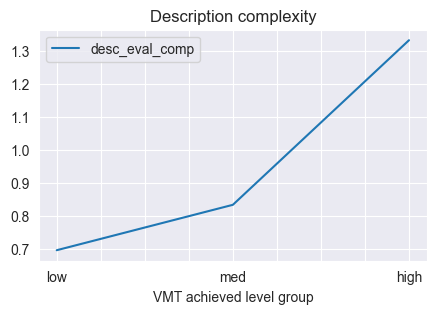

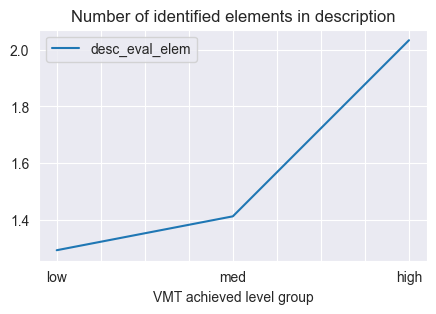

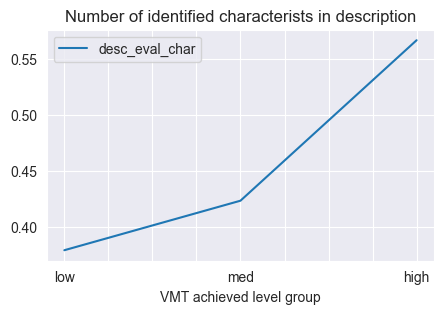

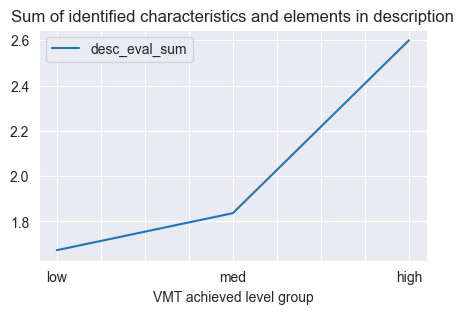

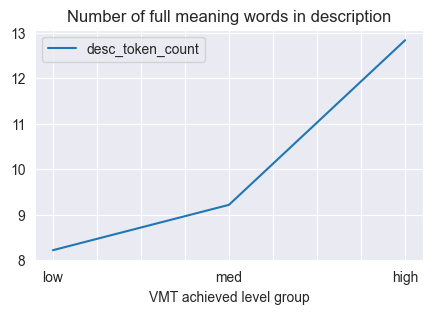

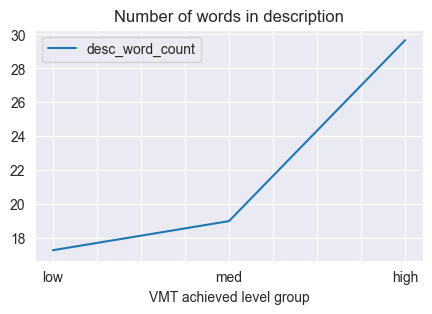

In [17]:
for column in open_text:
    my_mean_plot(data, column, 'vmt_levels_group', open_text[column], 'VMT achieved level group', '', ['low', 'med', 'high'])

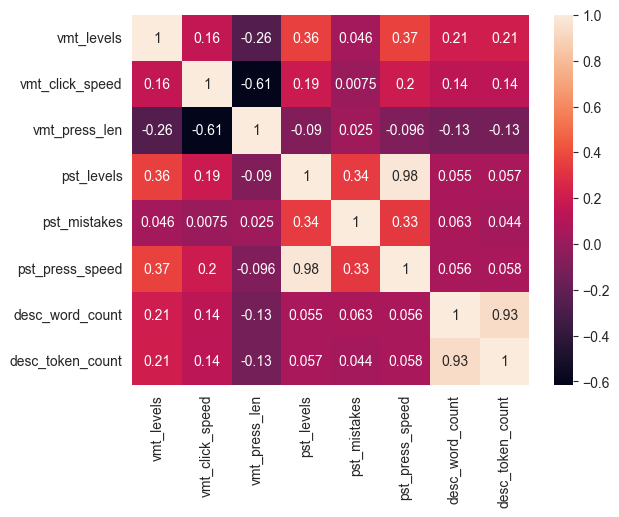

In [18]:
my_heatmap(data, ['vmt_levels', 'vmt_click_speed', 'vmt_press_len', 'pst_levels', 'pst_mistakes', 'pst_press_speed', 'desc_word_count', 'desc_token_count'])

In [19]:
my_chi(fixed_data, 'company', 'vmt_levels_group')

vmt_levels_group  high  low  med
company                         
0.0                  8   12   20
0.5                  9    5    9
1.0                157  157  337

pvalue: 0.4489021312650677

expected frequencies:
[[  9.74789916   9.74789916  20.50420168]
 [  5.60504202   5.60504202  11.78991597]
 [158.64705882 158.64705882 333.70588235]]



In [20]:
my_chi(fixed_data, 'purpose', 'vmt_levels_group')

vmt_levels_group  high  low  med
purpose                         
0.0                 13   27   46
0.5                 12    7   32
1.0                149  140  288

pvalue: 0.055096586563472466

expected frequencies:
[[ 20.95798319  20.95798319  44.08403361]
 [ 12.42857143  12.42857143  26.14285714]
 [140.61344538 140.61344538 295.77310924]]



In [21]:
my_chi(fixed_data, 'detail', 'vmt_levels_group')

vmt_levels_group  high  low  med
detail                          
0.0                116  125  266
0.5                  5    6    6
1.0                 53   43   94

pvalue: 0.4336950497205686

expected frequencies:
[[123.55462185 123.55462185 259.8907563 ]
 [  4.14285714   4.14285714   8.71428571]
 [ 46.30252101  46.30252101  97.39495798]]



In [22]:
my_chi(fixed_data, 'desc_eval_elem', 'vmt_levels_group', {1: [2], 3: [4, 5]})

vmt_levels_group  high  low  med
desc_eval_elem                  
0                   26   44   80
1                   82  105  228
3                   66   25   58

----> pvalue: 1.8581975673079107e-08

expected frequencies:
[[ 36.55462185  36.55462185  76.8907563 ]
 [101.13445378 101.13445378 212.73109244]
 [ 36.31092437  36.31092437  76.37815126]]

Post-hoc testing:
('high', 'low')     2.340875361700595e-06                   1
('high', 'med')     2.44237767374618e-07                   1
('low', 'med')        0.6343208564619943                   0





In [23]:
my_chi(fixed_data, 'desc_eval_char', 'vmt_levels_group', {2: [3]})

vmt_levels_group  high    low    med
desc_eval_char                      
0                 98.0  118.0  241.0
1                 57.0   46.0   99.0
2                 19.0   10.0   26.0

pvalue: 0.12549910457333732

expected frequencies:
[[111.3697479  111.3697479  234.2605042 ]
 [ 49.22689076  49.22689076 103.54621849]
 [ 13.40336134  13.40336134  28.19327731]]



In [24]:
my_chi(fixed_data, 'desc_eval_sum', 'vmt_levels_group', {1: [2], 3: [4, 5, 6]})

vmt_levels_group  high    low    med
desc_eval_sum                       
0                 13.0   24.0   55.0
1                 70.0  114.0  204.0
3                 91.0   36.0  107.0

----> pvalue: 3.491691721878685e-09

expected frequencies:
[[ 22.42016807  22.42016807  47.15966387]
 [ 94.55462185  94.55462185 198.8907563 ]
 [ 57.02521008  57.02521008 119.94957983]]

Post-hoc testing:
('high', 'low')     2.0418158207925696e-08                   1
('high', 'med')     8.126902943246782e-07                   1
('low', 'med')      0.025475964434848855                   1





In [25]:
my_chi(fixed_data, 'desc_eval_comp', 'vmt_levels_group')

vmt_levels_group  high  low  med
desc_eval_comp                  
0                   43   80  134
1                   61   73  169
2                   42   15   53
3                   28    6   10

----> pvalue: 3.611569786803585e-12

expected frequencies:
[[ 62.6302521   62.6302521  131.7394958 ]
 [ 73.84033613  73.84033613 155.31932773]
 [ 26.80672269  26.80672269  56.38655462]
 [ 10.72268908  10.72268908  22.55462185]]

Post-hoc testing:
('high', 'low')     1.551848110091492e-08                   1
('high', 'med')     3.2461042704920897e-09                   1
('low', 'med')      0.032846330658069633                   1





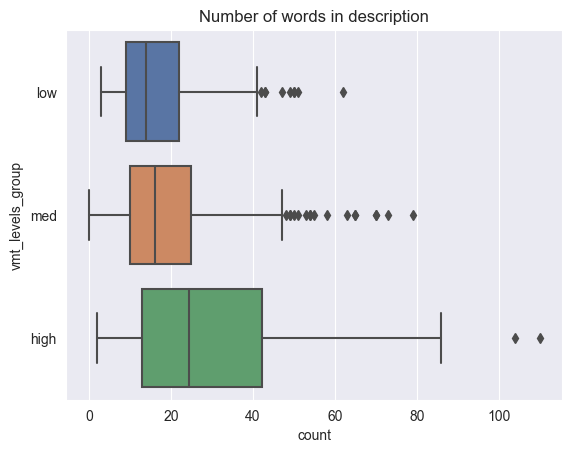

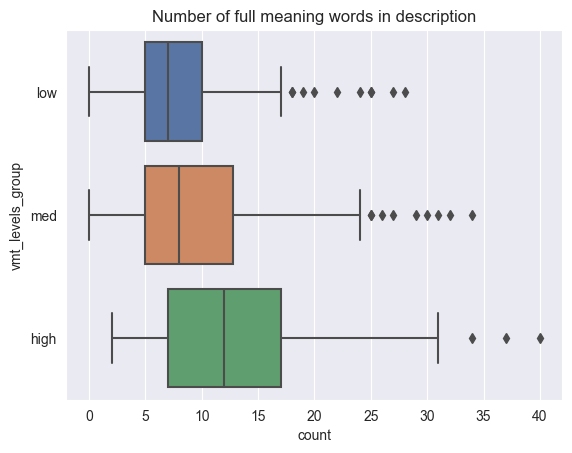

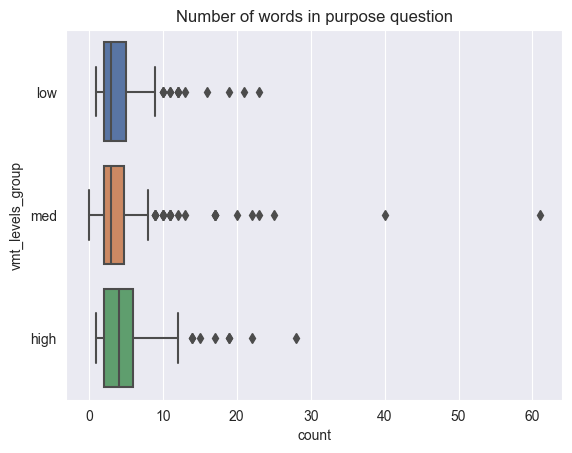

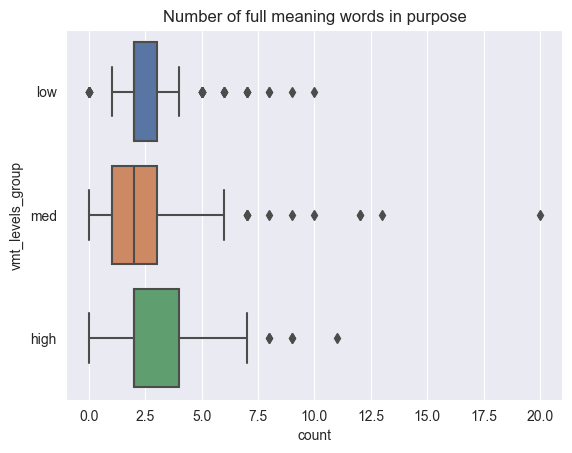

In [26]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    my_box_xy(data, column, 'vmt_levels_group', open_text[column], order=['low', 'med', 'high'])

In [27]:
for column in ['desc_word_count', 'desc_token_count']:
    my_test2(stats.kruskal, stats.mannwhitneyu, [
        data[data.vmt_levels_group == 'low'][column],
        data[data.vmt_levels_group == 'med'][column],
        data[data.vmt_levels_group == 'high'][column]
    ], column + ' (' + open_text[column] + ')', ['low', 'med', 'high'])

desc_word_count (Number of words in description)
low mean: 17.275862068965516
low std: 11.325647047495735
med mean: 18.991803278688526
med std: 13.858677654391057
high mean: 29.66111111111111
high std: 21.011612614940407

----> pvalue: 6.09606545315167e-10

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[3.61278660e-01 1.14067382e-08 1.14067382e-08]
[False  True  True]


desc_token_count (Number of full meaning words in description)
low mean: 8.218390804597702
low std: 5.094313473419563
med mean: 9.21584699453552
med std: 6.059510375679173
high mean: 12.833333333333334
high std: 7.719597060141786

----> pvalue: 1.5523049788732484e-09

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[1.14726079e-01 1.16047549e-08 1.42464575e-07]
[False  True  True]




[Text(0.5, 0, 'Number of significant words'),
 Text(0, 0.5, 'Short term memory group')]

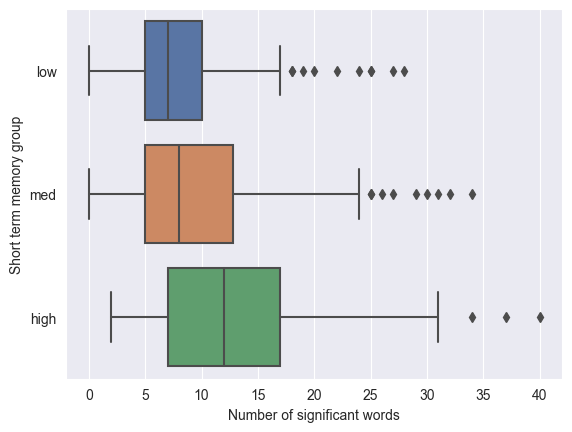

In [103]:
sns.boxplot(
    data=data,
    orient='h',
    x='desc_token_count',
    y='vmt_levels_group',
    palette='deep',
    order=['low', 'med', 'high']
).set(xlabel='Number of significant words', ylabel='Short term memory group')

In [29]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'vmt_levels_group')

vmt_levels_group       high  low  med
desc_word_count_group                
high                     88   42  104
low                      39   66  133
med                      47   66  129

----> pvalue: 5.379487908032127e-07

expected frequencies:
[[ 57.02521008  57.02521008 119.94957983]
 [ 58.          58.         122.        ]
 [ 58.97478992  58.97478992 124.05042017]]

Post-hoc testing:
('high', 'low')     5.511790038410257e-06                   1
('high', 'med')     5.511790038410257e-06                   1
('low', 'med')        0.4468304938013732                   0



vmt_levels_group        high  low  med
desc_token_count_group                
high                      80   30   92
low                       37   58  115
med                       57   86  159

----> pvalue: 5.982956773031265e-08

expected frequencies:
[[ 49.22689076  49.22689076 103.54621849]
 [ 51.17647059  51.17647059 107.64705882]
 [ 73.59663866  73.59663866 154.80672269]]

Post-hoc testing:
('high', 'low')

## PST passed levels

In [30]:
data[['task'] + list(attrak.keys()) + ['pst_levels_group']].groupby(['pst_levels_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
pst_levels_group                                                           
low                3.5  4.416667  4.953704  4.685185  4.671296  4.430556   
med                3.5  4.757576  5.053030  4.859848  4.871212  4.280303   
high               3.5  4.625000  4.929167  4.829167  4.770833  4.250000   

                       HQ2       HQ3       HQ4      ATT1      ATT2        PQ  \
pst_levels_group                                                               
low               4.148148  4.055556  4.134259  4.449074  4.648148  4.681713   
med               4.083333  3.875000  4.102273  4.473485  4.613636  4.885417   
high              4.045833  3.720833  3.904167  4.241667  4.491667  4.788542   

                        HQ       ATT  
pst_levels_group                      
low               4.192130  4.548611  
med               4.085227  4.543561  
high              3.980208  4.366667

In [31]:
data[['task'] + list(open_text.keys()) + ['pst_levels_group']].groupby(['pst_levels_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_levels_group                                                  
low                3.5  0.865741  0.784722             2.652778   
med                3.5  0.960227  0.878788             2.719697   
high               3.5  0.950000  0.862500             2.533333   

                  purpose_word_count    detail  desc_eval_comp  \
pst_levels_group                                                 
low                         4.430556  0.247685        0.740741   
med                         4.393939  0.261364        1.007576   
high                        3.754167  0.320833        1.000000   

                  desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_levels_group                                                  
low                     1.296296        0.342593       1.638889   
med                     1.659091        0.537879       2.196970   
high                    1.625000        0.445833       2.070833   

                  desc_token_count  desc_word_count  
pst_levels_group                                     
low                       8.976852        18.203704  
med                      10.685606        23.939394  
high                      9.804167        21.016667

In [32]:
data[['task'] + list(attrak.keys()) + ['pst_levels_group']].groupby(['pst_levels_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
pst_levels_group                                                               
low               1.711792  1.573768  1.390227  1.254930  1.545680  1.273995   
med               1.711069  1.620314  1.413215  1.316486  1.595647  1.301151   
high              1.711394  1.566183  1.315813  1.309757  1.552964  1.304963   

                       HQ2       HQ3       HQ4      ATT1      ATT2        PQ  \
pst_levels_group                                                               
low               1.299838  1.403208  1.310257  1.400066  1.335141  1.223425   
med               1.365193  1.262015  1.359712  1.505143  1.346155  1.300916   
high              1.307359  1.375664  1.364211  1.525218  1.325614  1.210495   

                        HQ       ATT  
pst_levels_group                      
low               1.177110  1.279061  
med               1.163991  1.340718  
high              1.178110  1.340133

In [33]:
data[['task'] + list(open_text.keys()) + ['pst_levels_group']].groupby(['pst_levels_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_levels_group                                                      
low               1.711792  0.327829  0.390227             2.213025   
med               1.711069  0.177995  0.299691             1.869566   
high              1.711394  0.198319  0.316641             1.488777   

                  purpose_word_count    detail  desc_eval_comp  \
pst_levels_group                                                 
low                         5.504737  0.425899        0.751685   
med                         4.327395  0.433686        0.880686   
high                        3.125342  0.461015        0.937369   

                  desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_levels_group                                                  
low                     1.054419        0.612460       1.144925   
med                     1.238357        0.663042       1.290146   
high                    1.224318        0.688506       1.396043   

                  desc_token_count  desc_word_count  
pst_levels_group                                     
low                       6.172288        13.624028  
med                       6.895997        17.817946  
high                      6.378506        16.020115

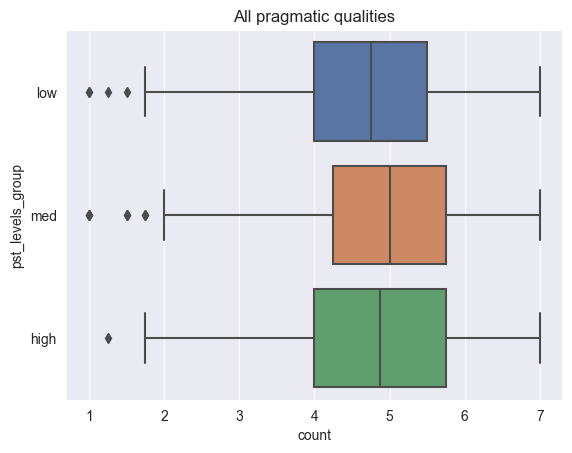

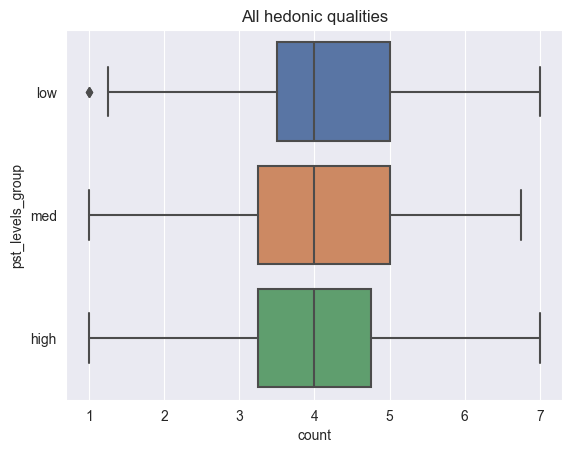

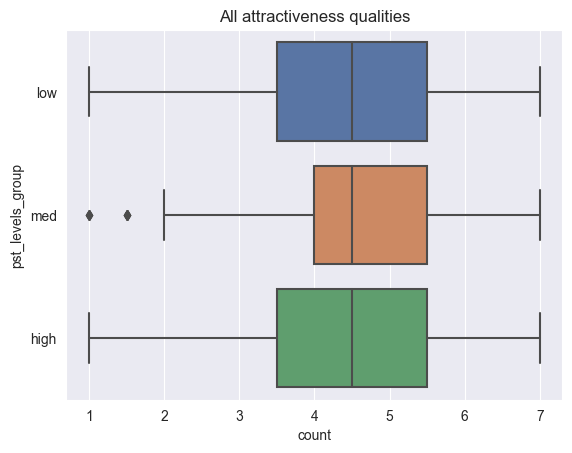

In [34]:
for column in ['PQ', 'HQ', 'ATT']:
    my_box_xy(data, column, 'pst_levels_group', attrak[column], order=['low', 'med', 'high'])

In [35]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.f_oneway, data, column, 'pst_levels_group', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.205992905174809

HQ (All hedonic qualities)
 pvalue: 0.15677303672310264

ATT (All attractiveness qualities)
 pvalue: 0.23072553278840593



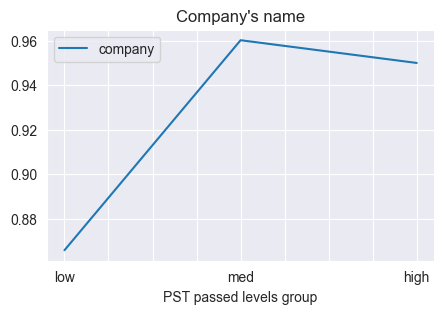

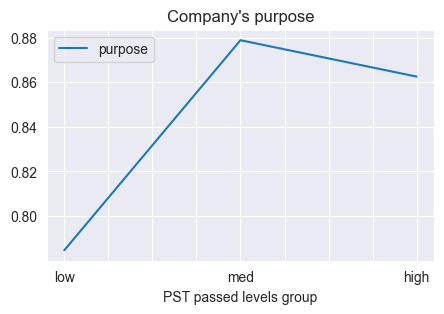

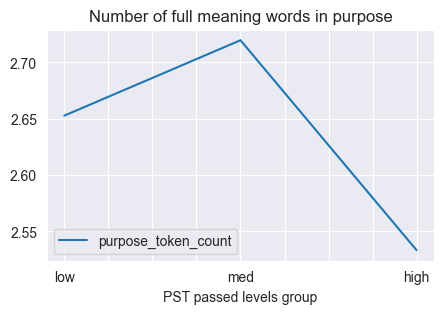

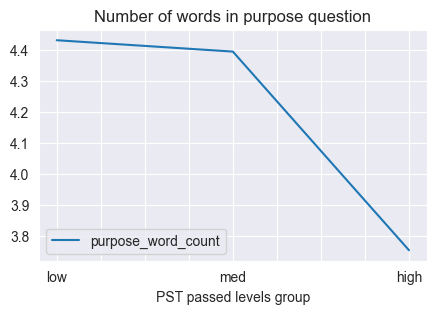

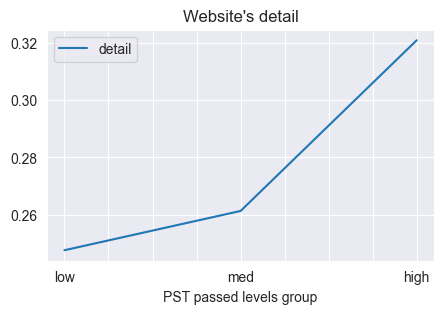

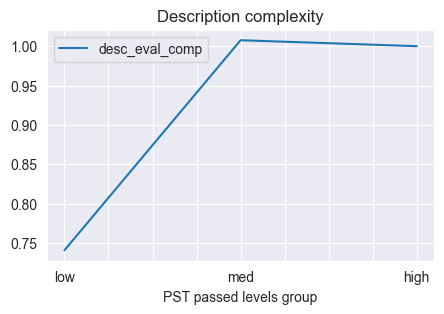

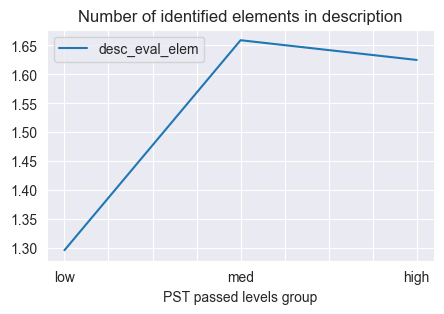

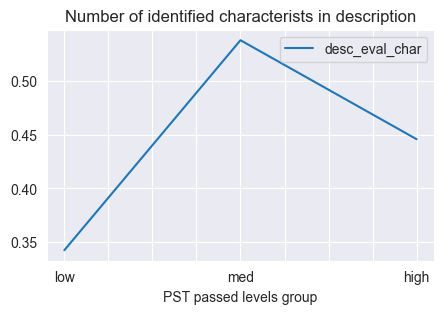

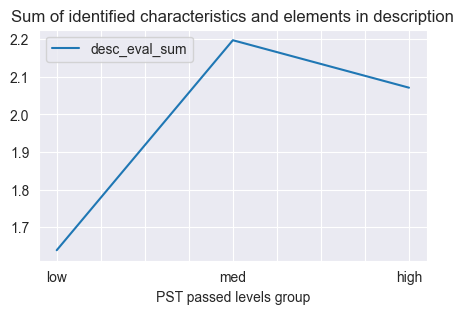

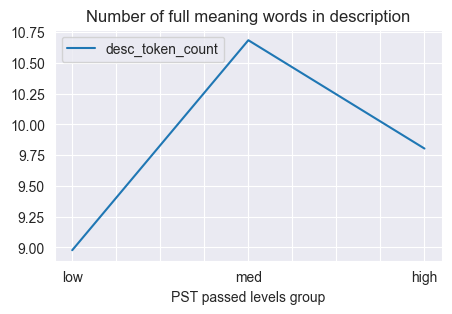

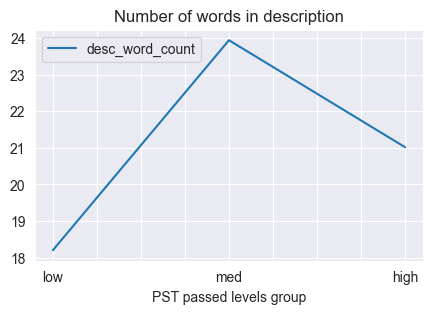

In [36]:
for column in open_text:
    my_mean_plot(data, column, 'pst_levels_group', open_text[column], 'PST passed levels group', '', ['low', 'med', 'high'])

In [37]:
my_chi(fixed_data, 'company', 'pst_levels_group', {1.0: [0.5]})

pst_levels_group  high  low  med
company                         
0.0                  8   25    7
1.0                226  191  257

----> pvalue: 2.7233360382343527e-05

expected frequencies:
[[ 13.1092437   12.10084034  14.78991597]
 [220.8907563  203.89915966 249.21008403]]

Post-hoc testing:
('high', 'low')     0.001724076259906396                   1
('high', 'med')                      1.0                   0
('low', 'med')      0.0006101151754475425                   1





In [38]:
my_chi(fixed_data, 'purpose', 'pst_levels_group', {1.0: [0.5]})

pst_levels_group  high  low  med
purpose                         
0.0                 24   39   23
1.0                210  177  241

----> pvalue: 0.00442598742817763

expected frequencies:
[[ 28.18487395  26.01680672  31.79831933]
 [205.81512605 189.98319328 232.20168067]]

Post-hoc testing:
('high', 'low')     0.025319829093394444                   1
('high', 'med')       0.6579379396107309                   0
('low', 'med')      0.011247171505539413                   1





In [39]:
my_chi(fixed_data, 'detail', 'pst_levels_group', {1.0: [0.5]})

pst_levels_group  high  low  med
detail                          
0.0                155  160  192
1.0                 79   56   72

pvalue: 0.13874388146209993

expected frequencies:
[[166.15966387 153.37815126 187.46218487]
 [ 67.84033613  62.62184874  76.53781513]]



In [40]:
my_chi(fixed_data, 'desc_eval_elem', 'pst_levels_group', {1: [2], 3: [4, 5]})

pst_levels_group   high    low    med
desc_eval_elem                       
0                  48.0   57.0   45.0
1                 127.0  129.0  159.0
3                  59.0   30.0   60.0

----> pvalue: 0.009207139433588994

expected frequencies:
[[ 49.15966387  45.37815126  55.46218487]
 [136.00840336 125.54621849 153.44537815]
 [ 48.83193277  45.07563025  55.09243697]]

Post-hoc testing:
('high', 'low')     0.022112731162684404                   1
('high', 'med')       0.2127670876397981                   0
('low', 'med')      0.022112731162684404                   1





In [41]:
my_chi(fixed_data, 'desc_eval_char', 'pst_levels_group', {2: [3]})

pst_levels_group   high    low    med
desc_eval_char                       
0                 155.0  155.0  147.0
1                  59.0   51.0   92.0
2                  20.0   10.0   25.0

----> pvalue: 0.0038164565163105488

expected frequencies:
[[149.77310924 138.25210084 168.97478992]
 [ 66.20168067  61.1092437   74.68907563]
 [ 18.02521008  16.63865546  20.33613445]]

Post-hoc testing:
('high', 'low')      0.08430908538789089                   0
('high', 'med')      0.04730675988149829                   1
('low', 'med')      0.0031295101798343244                   1





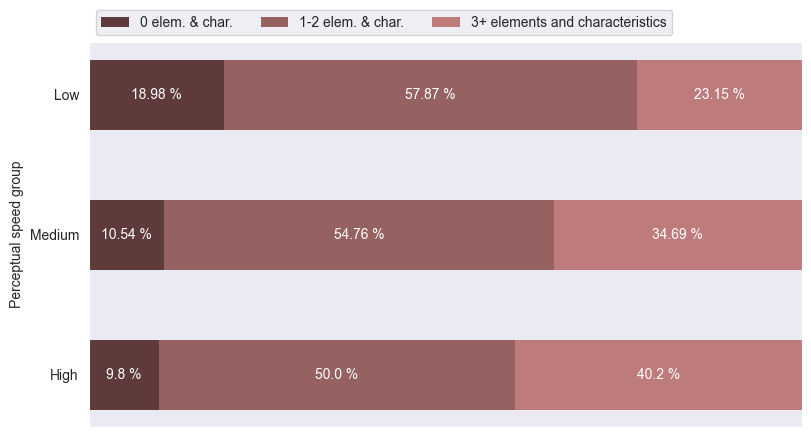

In [102]:
fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 100)
sums = [0, 0, 0]
colors = plt.colormaps['pink'](np.linspace(0.08, 0.35, 3))
legend = ['0 elem. & char.', '1-2 elem. & char.', '3+ elements and characteristics']
for index, i in enumerate([[41 / 2.16, 31 / 2.94, 20 / 2.04], [125 / 2.16, 161 / 2.94, 102 / 2.04], [50 / 2.16, 102 / 2.94, 82 / 2.04]]):
    curr_sum = i
    for i2, v2 in enumerate(curr_sum):
        curr_sum[i2] = round(v2, 2)
    r = ax.barh(
        ['Low', 'Medium', 'High'],
        curr_sum,
        left=sums,
        height=0.5, 
        label=legend[index],
        color=colors[index],
        linewidth=0
    )
    ax.bar_label(r, label_type='center', color='white', labels=map(lambda x: str(x) + ' %', curr_sum))
    ax.legend(ncol=len(legend), bbox_to_anchor=(0, 1),
              loc='lower left')
    for j, v in enumerate(sums):
        sums[j] += curr_sum[j]
ax.set_ylabel('Perceptual speed group')
plt.show()

In [43]:
my_chi(fixed_data, 'desc_eval_sum', 'pst_levels_group', {1: [2], 3: [4, 5, 6]})

pst_levels_group   high    low    med
desc_eval_sum                        
0                  33.0   36.0   23.0
1                 114.0  133.0  141.0
3                  87.0   47.0  100.0

----> pvalue: 0.00028920894437318496

expected frequencies:
[[ 30.1512605   27.83193277  34.01680672]
 [127.15966387 117.37815126 143.46218487]
 [ 76.68907563  70.78991597  86.5210084 ]]

Post-hoc testing:
('high', 'low')     0.0016372025506711464                   1
('high', 'med')       0.0602109818483294                   0
('low', 'med')      0.0004562076857900856                   1





In [44]:
my_chi(fixed_data, 'desc_eval_comp', 'pst_levels_group')

pst_levels_group  high  low  med
desc_eval_comp                  
0                   84   92   81
1                   91   92  120
2                   39   28   43
3                   20    4   20

----> pvalue: 0.010516380736157438

expected frequencies:
[[ 84.22689076  77.74789916  95.02521008]
 [ 99.30252101  91.66386555 112.03361345]
 [ 36.05042017  33.27731092  40.67226891]
 [ 14.42016807  13.31092437  16.26890756]]

Post-hoc testing:
('high', 'low')     0.010702257463705348                   1
('high', 'med')       0.3161510523737319                   0
('low', 'med')      0.010702257463705348                   1





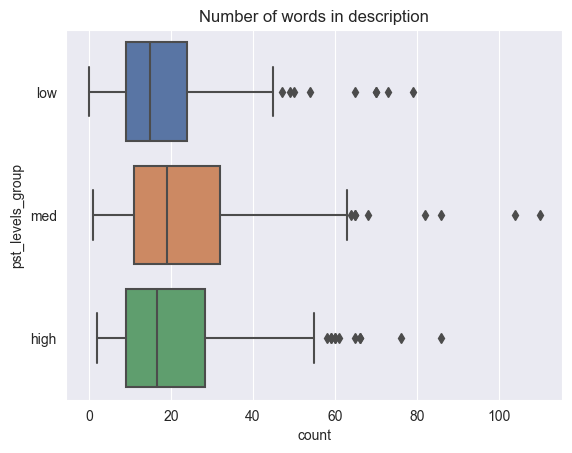

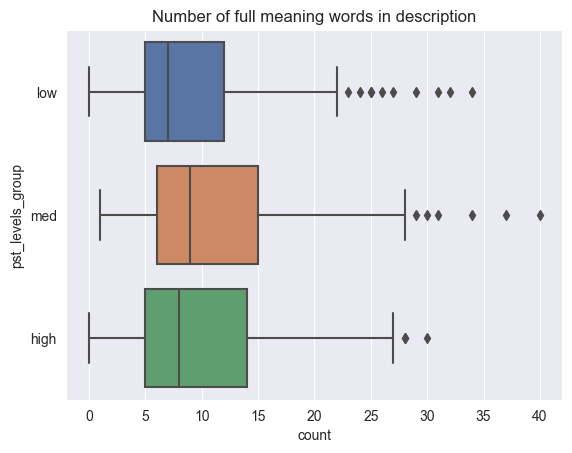

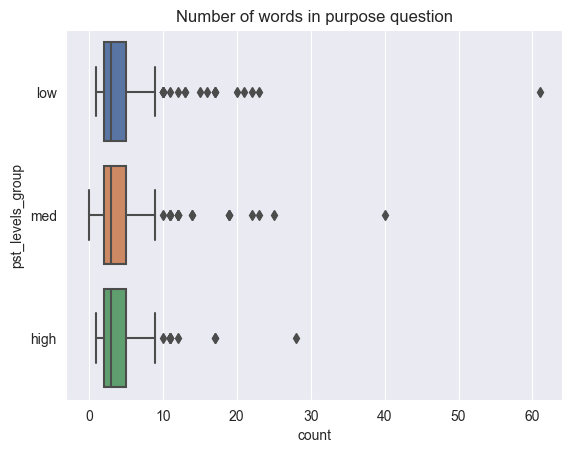

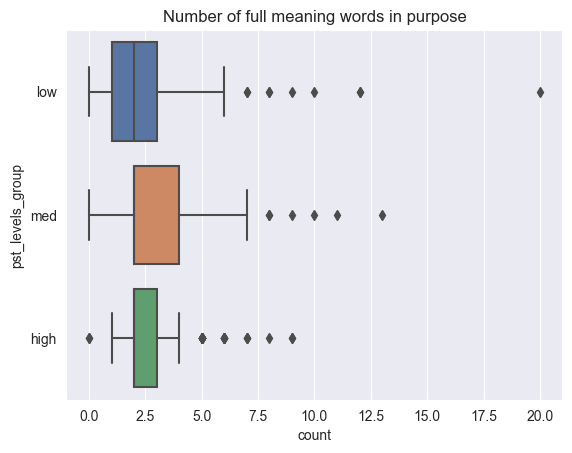

In [45]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    my_box_xy(data, column, 'pst_levels_group', open_text[column], order=['low', 'med', 'high'])

In [46]:
for column in ['desc_word_count', 'desc_token_count']:
    my_test2(stats.kruskal, stats.mannwhitneyu, [
        data[data.pst_levels_group == 'low'][column],
        data[data.pst_levels_group == 'med'][column],
        data[data.pst_levels_group == 'high'][column]
    ], column + ' (' + open_text[column] + ')', ['low', 'med', 'high'])

desc_word_count (Number of words in description)
low mean: 18.203703703703702
low std: 13.624027515887533
med mean: 23.939393939393938
med std: 17.817946084583347
high mean: 21.016666666666666
high std: 16.02011462269878

----> pvalue: 0.0010893288662680682

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.00061034 0.13857659 0.05526011]
[ True False False]


desc_token_count (Number of full meaning words in description)
low mean: 8.976851851851851
low std: 6.172287751683159
med mean: 10.68560606060606
med std: 6.89599688336098
high mean: 9.804166666666667
high std: 6.378505954750205

----> pvalue: 0.01562081084598402

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.01109252 0.17137214 0.17137214]
[ True False False]




In [47]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'pst_levels_group')

pst_levels_group       high  low  med
desc_word_count_group                
high                     74   55  105
low                      81   87   70
med                      79   74   89

----> pvalue: 0.005865380763465416

expected frequencies:
[[76.68907563 70.78991597 86.5210084 ]
 [78.         72.         88.        ]
 [79.31092437 73.21008403 89.4789916 ]]

Post-hoc testing:
('high', 'low')      0.13766427870350156                   0
('high', 'med')      0.09059758964924346                   0
('low', 'med')      0.0024922644131938386                   1



pst_levels_group        high  low  med
desc_token_count_group                
high                      66   49   87
low                       76   69   65
med                       92   98  112

pvalue: 0.06951340719141672

expected frequencies:
[[ 66.20168067  61.1092437   74.68907563]
 [ 68.82352941  63.52941176  77.64705882]
 [ 98.97478992  91.36134454 111.66386555]]



## PST correct levels

In [48]:
data[['task'] + list(attrak.keys()) + ['pst_levels_correct_group']].groupby(['pst_levels_correct_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4  \
pst_levels_correct_group                                                 
low                        3.5  4.435185  4.958333  4.680556  4.689815   
med                        3.5  4.700680  5.057823  4.880952  4.843537   
high                       3.5  4.666667  4.900000  4.800000  4.776190   

                               HQ1       HQ2       HQ3       HQ4      ATT1  \
pst_levels_correct_group                                                     
low                       4.351852  4.120370  4.037037  4.097222  4.421296   
med                       4.353741  4.122449  3.914966  4.102041  4.476190   
high                      4.223810  4.014286  3.661905  3.914286  4.233333   

                              ATT2        PQ        HQ       ATT  
pst_levels_correct_group                                          
low                       4.601852  4.690972  4.151620  4.511574  
med                       4.642857  4.870748  4.123299  4.559524  
high                      4.480952  4.785714  3.953571  4.357143

In [49]:
data[['task'] + list(open_text.keys()) + ['pst_levels_correct_group']].groupby(['pst_levels_correct_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_levels_correct_group                                                  
low                        3.5  0.872685  0.777778             2.731481   
med                        3.5  0.960884  0.863946             2.530612   
high                       3.5  0.940476  0.888095             2.690476   

                          purpose_word_count    detail  desc_eval_comp  \
pst_levels_correct_group                                                 
low                                 4.652778  0.266204        0.763889   
med                                 3.962585  0.258503        0.935374   
high                                4.038095  0.314286        1.076190   

                          desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_levels_correct_group                                                  
low                             1.310185        0.337963       1.648148   
med                             1.554422        0.523810       2.078231   
high                            1.752381        0.457143       2.209524   

                          desc_token_count  desc_word_count  
pst_levels_correct_group                                     
low                               9.222222        19.143519  
med                               9.789116        21.731293  
high                             10.680952        22.723810

In [50]:
data[['task'] + list(attrak.keys()) + ['pst_levels_correct_group']].groupby(['pst_levels_correct_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4  \
pst_levels_correct_group                                                     
low                       1.711792  1.612585  1.415241  1.302874  1.570391   
med                       1.710737  1.573739  1.332217  1.267651  1.559735   
high                      1.711906  1.590442  1.388435  1.326217  1.575046   

                               HQ1       HQ2       HQ3       HQ4      ATT1  \
pst_levels_correct_group                                                     
low                       1.263548  1.273834  1.407131  1.317076  1.438122   
med                       1.305294  1.374552  1.291709  1.386107  1.474856   
high                      1.313312  1.310534  1.343058  1.324154  1.533621   

                              ATT2        PQ        HQ       ATT  
pst_levels_correct_group                                          
low                       1.360163  1.249065  1.171060  1.302450  
med                       1.308283  1.242333  1.181979  1.309206  
high                      1.349151  1.257241  1.161297  1.360260

In [51]:
data[['task'] + list(open_text.keys()) + ['pst_levels_correct_group']].groupby(['pst_levels_correct_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_levels_correct_group                                                      
low                       1.711792  0.321688  0.393750             2.292988   
med                       1.710737  0.178161  0.317616             1.718425   
high                      1.711906  0.213267  0.286208             1.554252   

                          purpose_word_count    detail  desc_eval_comp  \
pst_levels_correct_group                                                 
low                                 5.627573  0.433715        0.774472   
med                                 4.007071  0.430706        0.877812   
high                                3.291060  0.462762        0.930043   

                          desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_levels_correct_group                                                  
low                             1.065784        0.633663       1.187648   
med                             1.206678        0.638186       1.289496   
high                            1.251074        0.705801       1.377851   

                          desc_token_count  desc_word_count  
pst_levels_correct_group                                     
low                               6.501282        15.019143  
med                               6.475716        16.867661  
high                              6.622285        16.269851

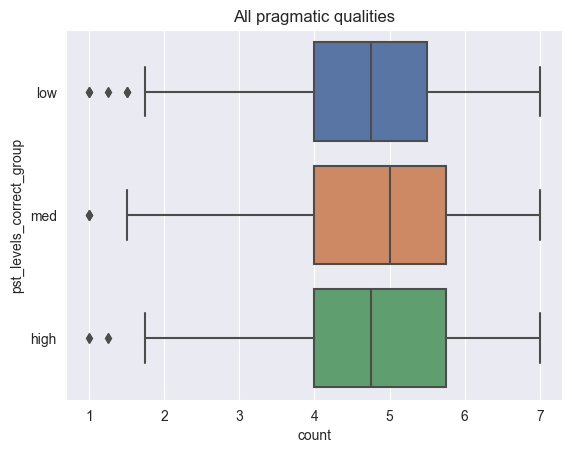

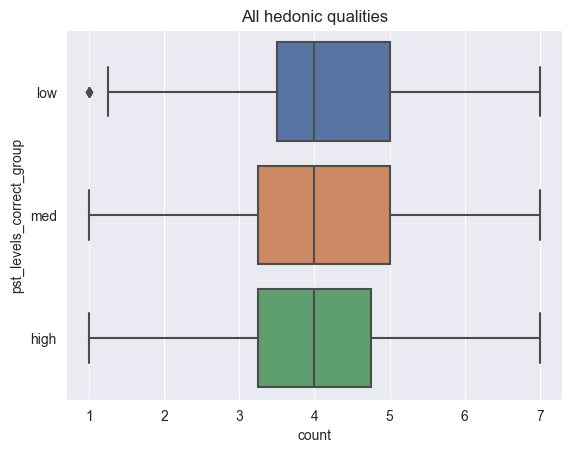

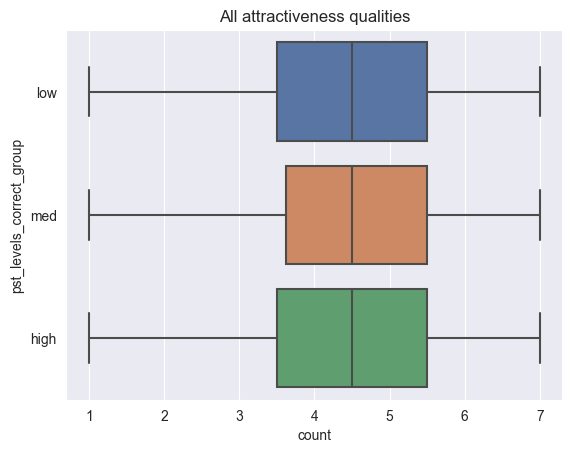

In [52]:
for column in ['PQ', 'HQ', 'ATT']:
    my_box_xy(data, column, 'pst_levels_correct_group', attrak[column], order=['low', 'med', 'high'])

In [53]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.f_oneway, data, column, 'pst_levels_correct_group', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.2747514297668175

HQ (All hedonic qualities)
 pvalue: 0.1624101080446941

ATT (All attractiveness qualities)
 pvalue: 0.22561779910144591



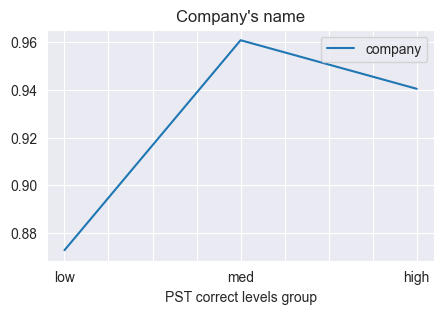

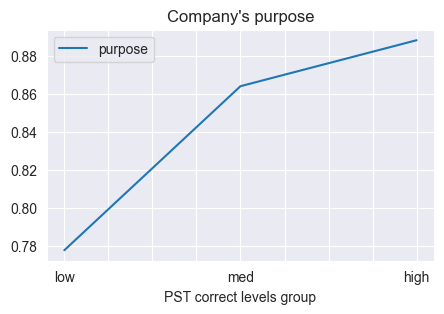

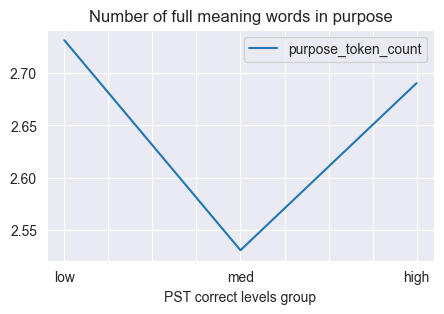

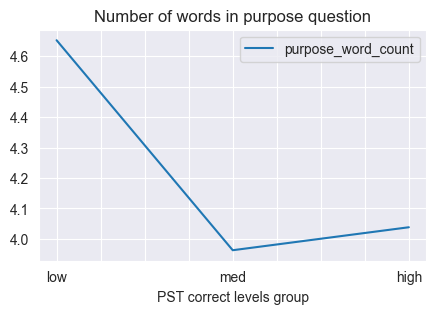

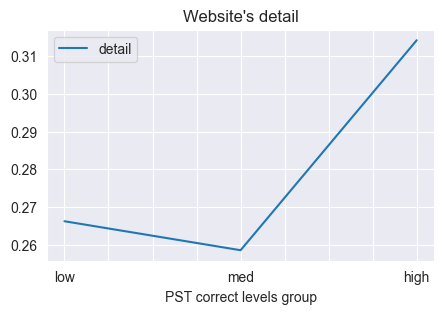

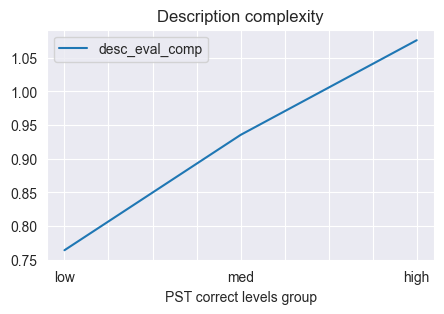

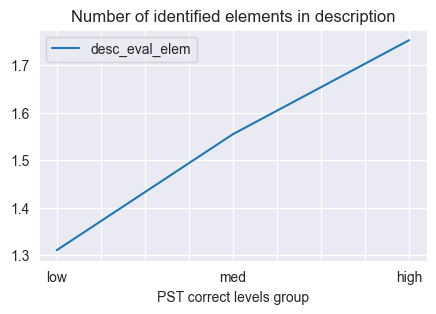

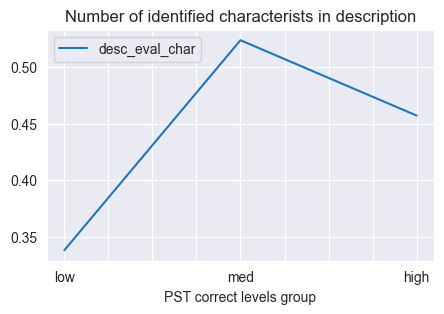

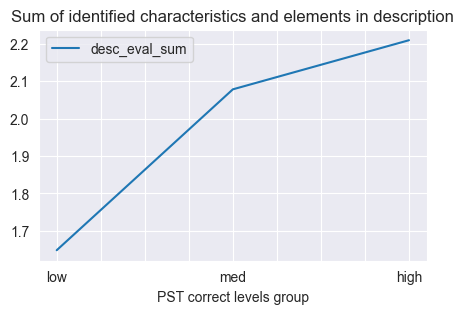

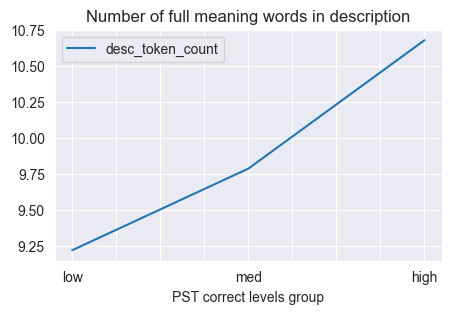

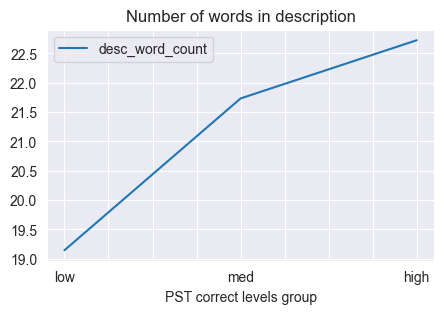

In [54]:
for column in open_text:
    my_mean_plot(data, column, 'pst_levels_correct_group', open_text[column], 'PST correct levels group', '', ['low', 'med', 'high'])

In [55]:
my_chi(fixed_data, 'company', 'pst_levels_correct_group')

pst_levels_correct_group  high  low  med
company                                 
0.0                          8   24    8
0.5                          9    7    7
1.0                        187  185  279

----> pvalue: 0.0005459184845950992

expected frequencies:
[[ 11.42857143  12.10084034  16.47058824]
 [  6.57142857   6.95798319   9.47058824]
 [186.         196.94117647 268.05882353]]

Post-hoc testing:
('high', 'low')     0.019390395556773136                   1
('high', 'med')      0.16378403458540122                   0
('low', 'med')      0.0013086053476539577                   1





In [56]:
my_chi(fixed_data, 'purpose', 'pst_levels_correct_group')

pst_levels_correct_group  high  low  med
purpose                                 
0.0                         16   40   30
0.5                         15   16   20
1.0                        173  160  244

----> pvalue: 0.010326207708528655

expected frequencies:
[[ 24.57142857  26.01680672  35.41176471]
 [ 14.57142857  15.42857143  21.        ]
 [164.85714286 174.55462185 237.58823529]]

Post-hoc testing:
('high', 'low')     0.015895860428711737                   1
('high', 'med')       0.6520729625900882                   0
('low', 'med')      0.023042354956637947                   1





In [57]:
my_chi(fixed_data, 'detail', 'pst_levels_correct_group', {1.0: [0.5]})

pst_levels_correct_group  high  low  med
detail                                  
0.0                        138  155  214
1.0                         66   61   80

pvalue: 0.44227823906848707

expected frequencies:
[[144.85714286 153.37815126 208.76470588]
 [ 59.14285714  62.62184874  85.23529412]]



In [58]:
my_chi(fixed_data, 'desc_eval_elem', 'pst_levels_correct_group', {1: [2], 3: [4, 5]})

pst_levels_correct_group  high  low  med
desc_eval_elem                          
0                           35   57   58
1                          111  130  174
3                           58   29   62

----> pvalue: 0.0022337879428798754

expected frequencies:
[[ 42.85714286  45.37815126  61.76470588]
 [118.57142857 125.54621849 170.88235294]
 [ 42.57142857  45.07563025  61.35294118]]

Post-hoc testing:
('high', 'low')     0.0009596520665083147                   1
('high', 'med')       0.0659973257385441                   0
('low', 'med')       0.03892967702791964                   1





In [59]:
my_chi(fixed_data, 'desc_eval_char', 'pst_levels_correct_group', {2: [3]})

pst_levels_correct_group   high    low    med
desc_eval_char                               
0                         135.0  159.0  163.0
1                          50.0   44.0  108.0
2                          19.0   13.0   23.0

----> pvalue: 0.00026983686334373154

expected frequencies:
[[130.57142857 138.25210084 188.17647059]
 [ 57.71428571  61.1092437   83.17647059]
 [ 15.71428571  16.63865546  22.64705882]]

Post-hoc testing:
('high', 'low')      0.08829632043032168                   0
('high', 'med')     0.015941490911007394                   1
('low', 'med')      0.0003230504515441377                   1





In [60]:
my_chi(fixed_data, 'desc_eval_sum', 'pst_levels_correct_group', {1: [2], 3: [4, 5, 6]})

pst_levels_correct_group   high    low    med
desc_eval_sum                                
0                          20.0   41.0   31.0
1                         102.0  125.0  161.0
3                          82.0   50.0  102.0

----> pvalue: 0.0004854720495136353

expected frequencies:
[[ 26.28571429  27.83193277  37.88235294]
 [110.85714286 117.37815126 159.76470588]
 [ 66.85714286  70.78991597  96.35294118]]

Post-hoc testing:
('high', 'low')     0.0006140533345033105                   1
('high', 'med')       0.2799666631785751                   0
('low', 'med')      0.0024081842266106017                   1





In [61]:
my_chi(fixed_data, 'desc_eval_comp', 'pst_levels_correct_group')

pst_levels_correct_group  high  low  med
desc_eval_comp                          
0                           64   91  102
1                           83   90  130
2                           39   30   41
3                           18    5   21

----> pvalue: 0.02405581497705951

expected frequencies:
[[ 73.42857143  77.74789916 105.82352941]
 [ 86.57142857  91.66386555 124.76470588]
 [ 31.42857143  33.27731092  45.29411765]
 [ 12.57142857  13.31092437  18.11764706]]

Post-hoc testing:
('high', 'low')     0.012867499959240409                   1
('high', 'med')      0.19020811291626816                   0
('low', 'med')       0.05554066647696716                   0





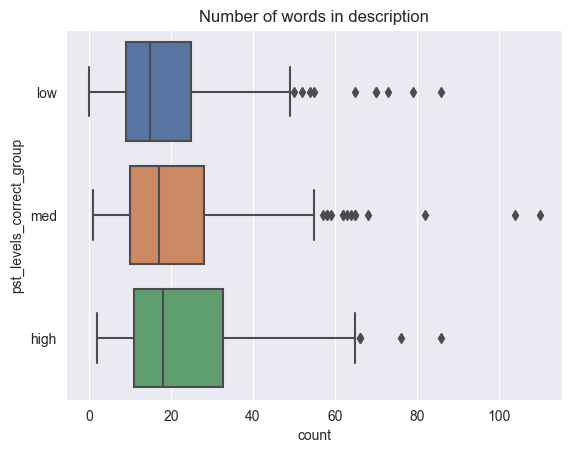

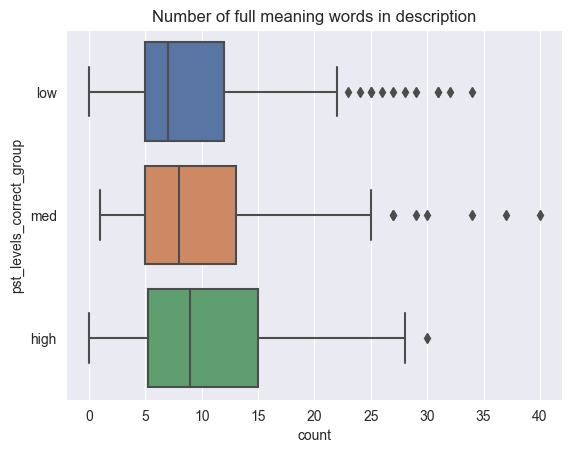

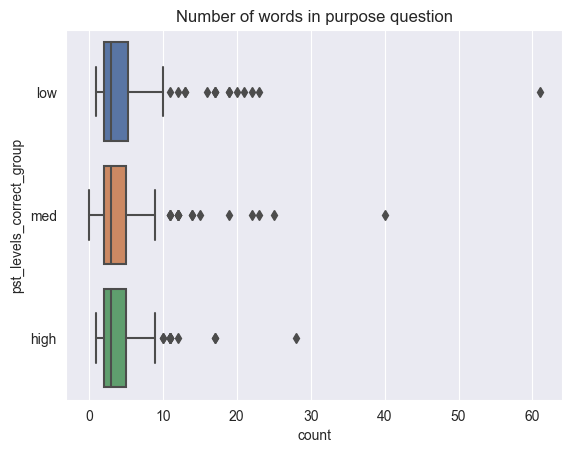

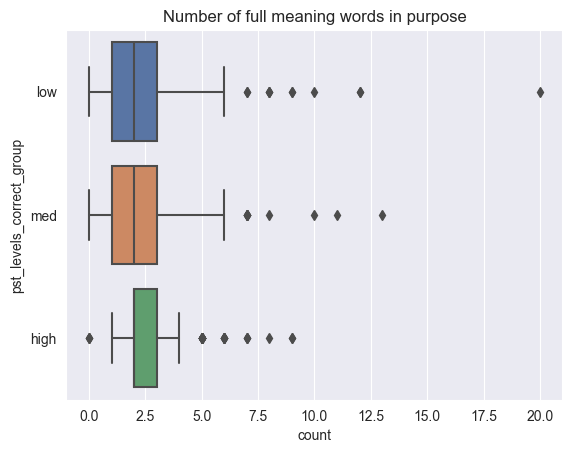

In [62]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    my_box_xy(data, column, 'pst_levels_correct_group', open_text[column], order=['low', 'med', 'high'])

In [63]:
for column in ['desc_word_count', 'desc_token_count']:
    my_test2(stats.kruskal, stats.mannwhitneyu, [
        data[data.pst_levels_correct_group == 'low'][column],
        data[data.pst_levels_correct_group == 'med'][column],
        data[data.pst_levels_correct_group == 'high'][column]
    ], column + ' (' + open_text[column] + ')', ['low', 'med', 'high'])

desc_word_count (Number of words in description)
low mean: 19.14351851851852
low std: 15.019142967207646
med mean: 21.731292517006803
med std: 16.8676611759171
high mean: 22.723809523809525
high std: 16.26985073177866

----> pvalue: 0.03658731688081625

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.1096873  0.03727055 0.33998364]
[False  True False]


desc_token_count (Number of full meaning words in description)
low mean: 9.222222222222221
low std: 6.501281924871945
med mean: 9.789115646258503
med std: 6.475716036961353
high mean: 10.68095238095238
high std: 6.622285056965762

----> pvalue: 0.03263242308574276

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.21598355 0.02899385 0.16445411]
[False  True False]




In [64]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'pst_levels_correct_group')

pst_levels_correct_group  high  low  med
desc_word_count_group                   
high                        75   59  100
low                         59   86   93
med                         70   71  101

pvalue: 0.11815476983518965

expected frequencies:
[[66.85714286 70.78991597 96.35294118]
 [68.         72.         98.        ]
 [69.14285714 73.21008403 99.64705882]]

pst_levels_correct_group  high  low  med
desc_token_count_group                  
high                        69   50   83
low                         53   70   87
med                         82   96  124

pvalue: 0.1878570684672161

expected frequencies:
[[ 57.71428571  61.1092437   83.17647059]
 [ 60.          63.52941176  86.47058824]
 [ 86.28571429  91.36134454 124.35294118]]



## PST mistakes

In [65]:
data[['task'] + list(attrak.keys()) + ['pst_mistakes_group']].groupby(['pst_mistakes_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
pst_mistakes_group                                                           
low                  3.5  4.679012  5.191358  4.851852  4.969136  4.475309   
med                  3.5  4.637427  4.880117  4.736842  4.766082  4.245614   
high                 3.5  4.518519  4.986111  4.851852  4.652778  4.305556   

                         HQ2       HQ3       HQ4      ATT1      ATT2  \
pst_mistakes_group                                                     
low                 4.246914  3.981481  4.117284  4.481481  4.648148   
med                 3.967836  3.836257  4.011696  4.356725  4.538012   
high                4.166667  3.865741  4.046296  4.370370  4.606481   

                          PQ        HQ       ATT  
pst_mistakes_group                                
low                 4.922840  4.205247  4.564815  
med                 4.755117  4.015351  4.447368  
high                4.752315  4.096065  4.488426

In [66]:
data[['task'] + list(open_text.keys()) + ['pst_mistakes_group']].groupby(['pst_mistakes_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_mistakes_group                                                  
low                  3.5  0.953704  0.913580             2.567901   
med                  3.5  0.913743  0.807018             2.549708   
high                 3.5  0.932870  0.854167             2.828704   

                    purpose_word_count    detail  desc_eval_comp  \
pst_mistakes_group                                                 
low                           3.759259  0.293210        1.080247   
med                           4.108187  0.283626        0.754386   
high                          4.648148  0.254630        1.078704   

                    desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_mistakes_group                                                  
low                       1.839506        0.432099       2.271605   
med                       1.304094        0.435673       1.739766   
high                      1.685185        0.481481       2.166667   

                    desc_token_count  desc_word_count  
pst_mistakes_group                                     
low                        11.141975        22.993827  
med                         8.725146        18.874269  
high                       10.759259        23.685185

In [67]:
data[['task'] + list(attrak.keys()) + ['pst_mistakes_group']].groupby(['pst_mistakes_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4  \
pst_mistakes_group                                                     
low                 1.713121  1.530860  1.278265  1.247219  1.476200   
med                 1.710327  1.589040  1.370066  1.311259  1.550032   
high                1.711792  1.645185  1.435365  1.310528  1.649465   

                         HQ1       HQ2       HQ3       HQ4      ATT1  \
pst_mistakes_group                                                     
low                 1.216862  1.266196  1.228402  1.306390  1.423940   
med                 1.330191  1.304904  1.320746  1.346172  1.479557   
high                1.290093  1.387653  1.473970  1.386877  1.534670   

                        ATT2        PQ        HQ       ATT  
pst_mistakes_group                                          
low                 1.253429  1.202444  1.113826  1.272181  
med                 1.345140  1.265871  1.169294  1.324872  
high                1.383543  1.256146  1.222025  1.360952

In [68]:
data[['task'] + list(open_text.keys()) + ['pst_mistakes_group']].groupby(['pst_mistakes_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
pst_mistakes_group                                                      
low                 1.713121  0.199421  0.258881             1.648928   
med                 1.710327  0.266427  0.368333             1.718158   
high                1.711792  0.229018  0.328182             2.210611   

                    purpose_word_count    detail  desc_eval_comp  \
pst_mistakes_group                                                 
low                           3.142190  0.454942        0.918941   
med                           3.946489  0.443223        0.783571   
high                          5.650791  0.428602        0.919206   

                    desc_eval_elem  desc_eval_char  desc_eval_sum  \
pst_mistakes_group                                                  
low                       1.346325        0.609210       1.383239   
med                       1.044991        0.654524       1.234688   
high                      1.213476        0.708506       1.286784   

                    desc_token_count  desc_word_count  
pst_mistakes_group                                     
low                         7.360181        17.788089  
med                         5.588573        13.596359  
high                        6.994177        18.170330

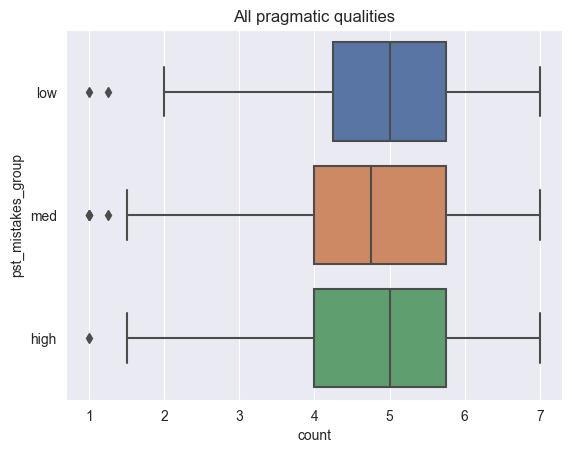

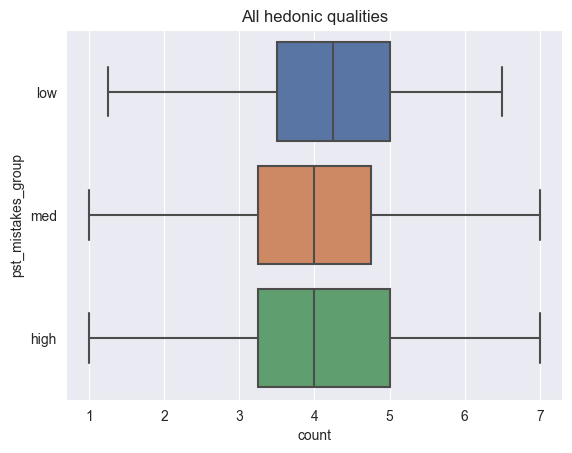

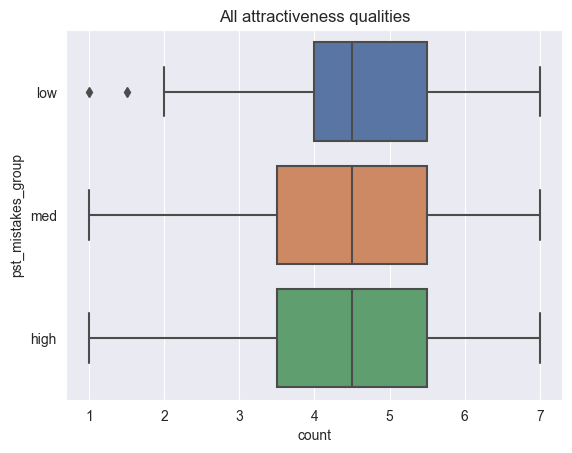

In [69]:
for column in ['PQ', 'HQ', 'ATT']:
    my_box_xy(data, column, 'pst_mistakes_group', attrak[column], order=['low', 'med', 'high'])

In [70]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.f_oneway, data, column, 'pst_mistakes_group', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.3181456498235889

HQ (All hedonic qualities)
 pvalue: 0.23268375620673867

ATT (All attractiveness qualities)
 pvalue: 0.6488522373096683



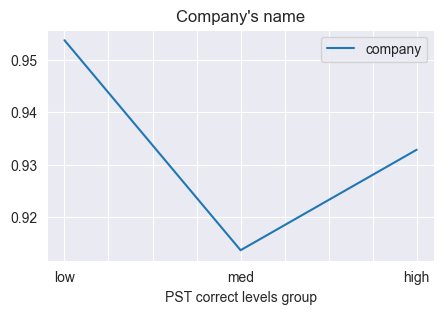

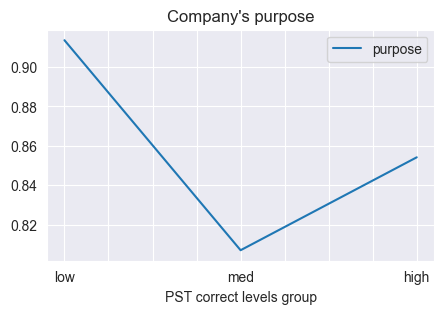

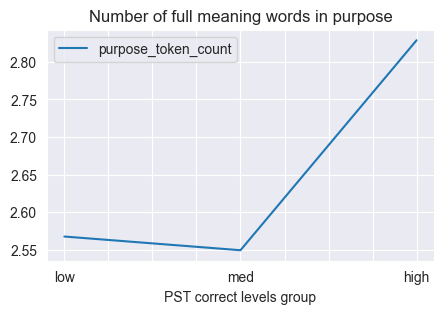

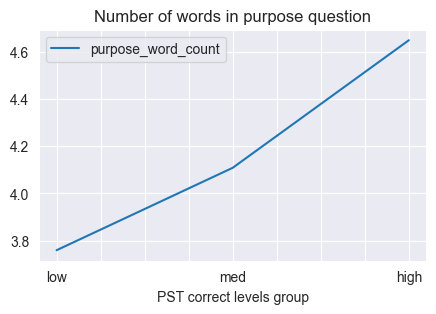

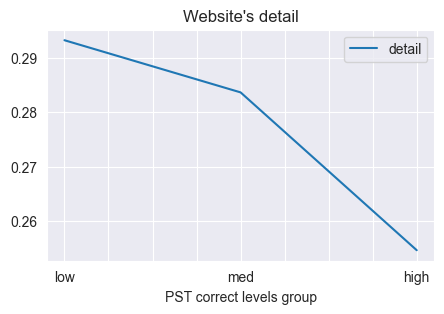

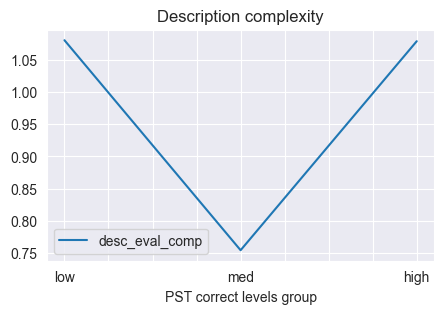

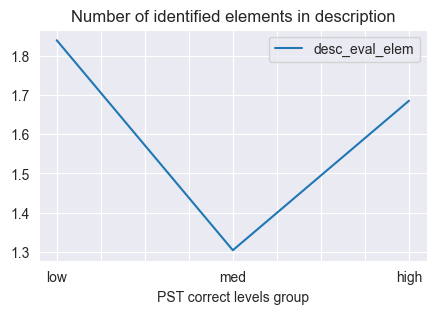

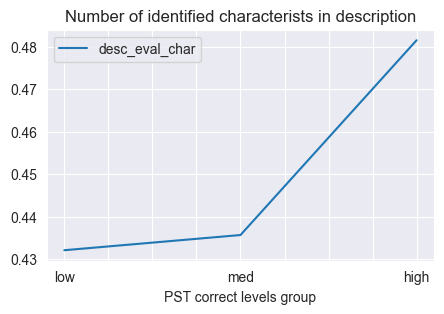

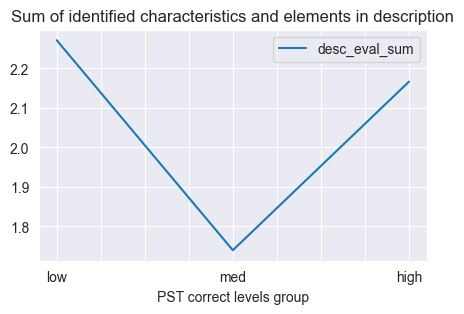

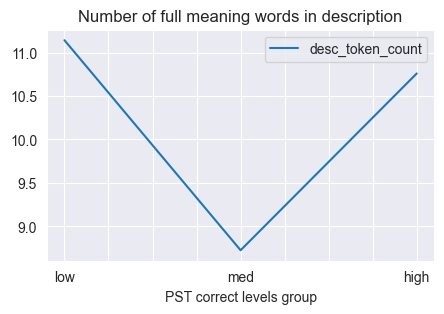

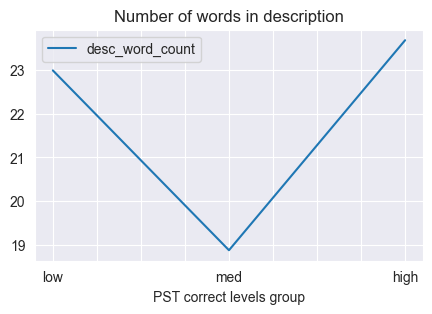

In [71]:
for column in open_text:
    my_mean_plot(data, column, 'pst_mistakes_group', open_text[column], 'PST correct levels group', '', ['low', 'med', 'high'])

In [72]:
my_chi(fixed_data, 'company', 'pst_mistakes_group', {1.0: [0.5]})

pst_mistakes_group  high  low  med
company                           
0.0                   10    6   24
1.0                  206  156  312

pvalue: 0.22329298757515906

expected frequencies:
[[ 12.10084034   9.07563025  18.82352941]
 [203.89915966 152.92436975 317.17647059]]



In [73]:
my_chi(fixed_data, 'purpose', 'pst_mistakes_group', {1.0: [0.5]})

pst_mistakes_group  high  low  med
purpose                           
0.0                   24   10   52
1.0                  192  152  284

----> pvalue: 0.010129251168855337

expected frequencies:
[[ 26.01680672  19.51260504  40.47058824]
 [189.98319328 142.48739496 295.52941176]]

Post-hoc testing:
('high', 'low')      0.16161317988100435                   0
('high', 'med')      0.16161317988100435                   0
('low', 'med')      0.015351860110215299                   1





In [74]:
my_chi(fixed_data, 'detail', 'pst_mistakes_group', {1.0: [0.5]})

pst_mistakes_group  high  low  med
detail                            
0.0                  158  114  235
1.0                   58   48  101

pvalue: 0.7051931508233629

expected frequencies:
[[153.37815126 115.03361345 238.58823529]
 [ 62.62184874  46.96638655  97.41176471]]



In [75]:
my_chi(fixed_data, 'desc_eval_elem', 'pst_mistakes_group', {1: [2], 3: [4, 5]})

pst_mistakes_group  high  low  med
desc_eval_elem                    
0                     36   30   84
1                    125   80  210
3                     55   52   42

----> pvalue: 2.472376805533857e-06

expected frequencies:
[[ 45.37815126  34.03361345  70.58823529]
 [125.54621849  94.15966387 195.29411765]
 [ 45.07563025  33.80672269  70.11764706]]

Post-hoc testing:
('high', 'low')      0.10545094012759311                   0
('high', 'med')     0.00018075634857407394                   1
('low', 'med')      3.238661632415861e-06                   1





In [76]:
my_chi(fixed_data, 'desc_eval_char', 'pst_mistakes_group', {2: [3]})

pst_mistakes_group   high    low    med
desc_eval_char                         
0                   135.0  102.0  220.0
1                    62.0   50.0   90.0
2                    19.0   10.0   26.0

pvalue: 0.7894612686734741

expected frequencies:
[[138.25210084 103.68907563 215.05882353]
 [ 61.1092437   45.83193277  95.05882353]
 [ 16.63865546  12.4789916   25.88235294]]



In [77]:
my_chi(fixed_data, 'desc_eval_sum', 'pst_mistakes_group', {1: [2], 3: [4, 5, 6]})

pst_mistakes_group   high   low    med
desc_eval_sum                         
0                    22.0  20.0   50.0
1                   104.0  74.0  210.0
3                    90.0  68.0   76.0

----> pvalue: 4.575025869184399e-06

expected frequencies:
[[ 27.83193277  20.87394958  43.29411765]
 [117.37815126  88.03361345 182.58823529]
 [ 70.78991597  53.09243697 110.11764706]]

Post-hoc testing:
('high', 'low')                      1.0                   0
('high', 'med')     3.2827044897562084e-05                   1
('low', 'med')      4.350984487263467e-05                   1





In [78]:
my_chi(fixed_data, 'desc_eval_comp', 'pst_mistakes_group')

pst_mistakes_group  high  low  med
desc_eval_comp                    
0                     65   48  144
1                     87   67  149
2                     46   33   31
3                     18   14   12

----> pvalue: 1.9522816840965992e-05

expected frequencies:
[[ 77.74789916  58.31092437 120.94117647]
 [ 91.66386555  68.74789916 142.58823529]
 [ 33.27731092  24.95798319  51.76470588]
 [ 13.31092437   9.98319328  20.70588235]]

Post-hoc testing:
('high', 'low')                      1.0                   0
('high', 'med')     3.849911490139736e-05                   1
('low', 'med')      9.892290721406585e-05                   1





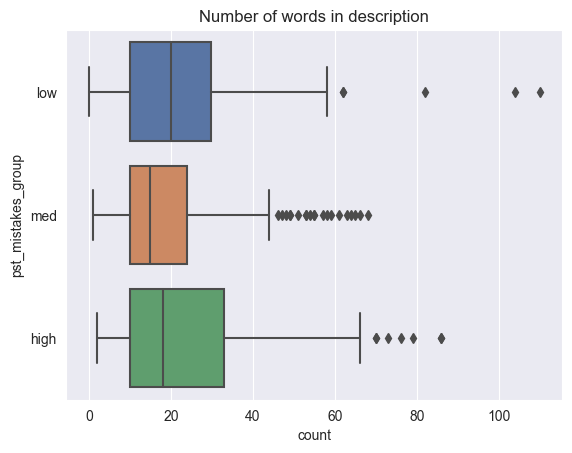

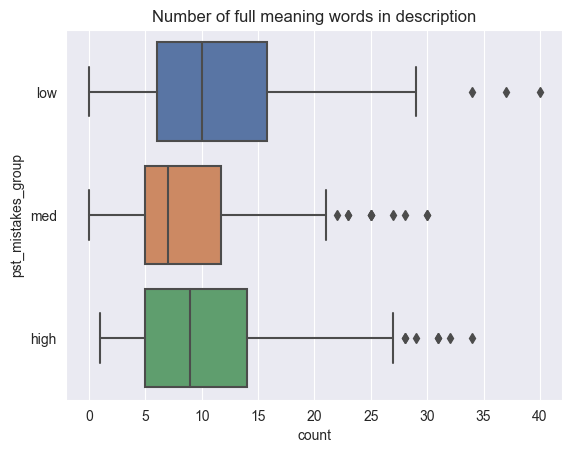

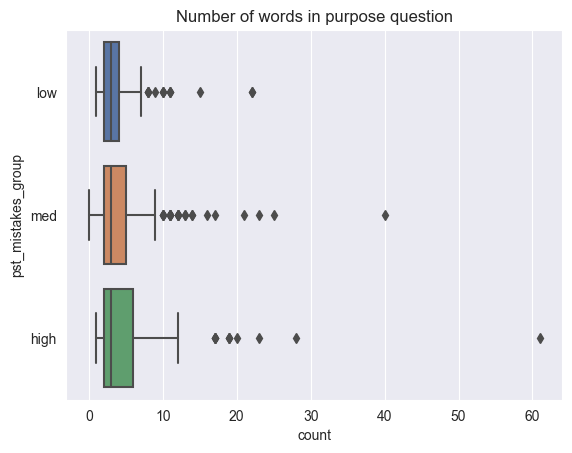

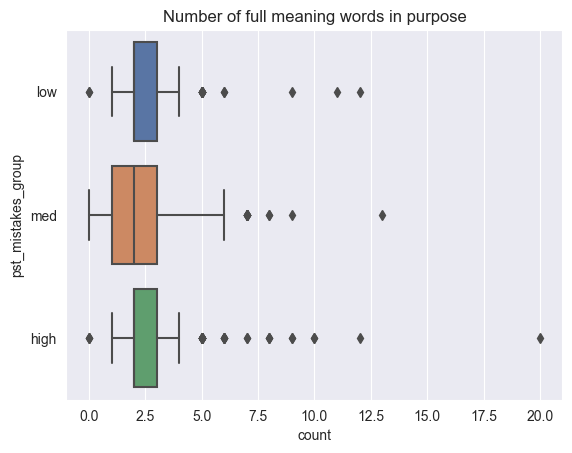

In [79]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    my_box_xy(data, column, 'pst_mistakes_group', open_text[column], order=['low', 'med', 'high'])

In [80]:
for column in ['desc_word_count', 'desc_token_count']:
    my_test2(stats.kruskal, stats.mannwhitneyu, [
        data[data.pst_mistakes_group == 'low'][column],
        data[data.pst_mistakes_group == 'med'][column],
        data[data.pst_mistakes_group == 'high'][column]
    ], column + ' (' + open_text[column] + ')', ['low', 'med', 'high'])

desc_word_count (Number of words in description)
low mean: 22.993827160493826
low std: 17.78808901281149
med mean: 18.874269005847953
med std: 13.59635900537653
high mean: 23.685185185185187
high std: 18.170330095501853

----> pvalue: 0.007675580672555322

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.02063336 0.98367735 0.02063336]
[ True False  True]


desc_token_count (Number of full meaning words in description)
low mean: 11.141975308641975
low std: 7.36018100299864
med mean: 8.725146198830409
med std: 5.588573318664971
high mean: 10.75925925925926
high std: 6.994177472620959

----> pvalue: 0.0002366982654454494

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.00136814 0.57087386 0.00207931]
[ True False  True]




In [81]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'pst_mistakes_group')

pst_mistakes_group     high  low  med
desc_word_count_group                
high                     81   69   84
low                      63   50  125
med                      72   43  127

----> pvalue: 0.000633254833254534

expected frequencies:
[[ 70.78991597  53.09243697 110.11764706]
 [ 72.          54.         112.        ]
 [ 73.21008403  54.90756303 113.88235294]]

Post-hoc testing:
('high', 'low')       0.1798345482076599                   0
('high', 'med')     0.006475536499511451                   1
('low', 'med')      0.0008595587573042771                   1



pst_mistakes_group      high  low  med
desc_token_count_group                
high                      74   59   69
low                       59   37  114
med                       83   66  153

----> pvalue: 0.0004219888228540548

expected frequencies:
[[ 61.1092437   45.83193277  95.05882353]
 [ 63.52941176  47.64705882  98.82352941]
 [ 91.36134454  68.5210084  142.11764706]]

Post-hoc testing:
('high', 'low')  

## VMT click speed

In [82]:
data[['task'] + list(attrak.keys()) + ['vmt_click_speed_group']].groupby(['vmt_click_speed_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4       HQ1  \
vmt_click_speed_group                                                           
low                     3.5  4.479167  4.945833  4.750000  4.658333  4.325000   
med                     3.5  4.612500  5.012500  4.850000  4.800000  4.362500   
high                    3.5  4.741667  4.987500  4.791667  4.875000  4.258333   

                            HQ2       HQ3       HQ4      ATT1      ATT2  \
vmt_click_speed_group                                                     
low                    4.204167  3.916667  4.041667  4.354167  4.554167   
med                    4.054167  3.883333  4.025000  4.375000  4.604167   
high                   4.012500  3.833333  4.070833  4.437500  4.591667   

                             PQ        HQ       ATT  
vmt_click_speed_group                                
low                    4.708333  4.121875  4.454167  
med                    4.818750  4.081250  4.489583  
high                   4.848958  4.043750  4.514583

In [83]:
data[['task'] + list(open_text.keys()) + ['vmt_click_speed_group']].groupby(['vmt_click_speed_group']).mean().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
vmt_click_speed_group                                                  
low                     3.5  0.893750  0.779167             2.570833   
med                     3.5  0.952083  0.854167             2.600000   
high                    3.5  0.939583  0.902083             2.741667   

                       purpose_word_count    detail  desc_eval_comp  \
vmt_click_speed_group                                                 
low                              4.104167  0.283333        0.775000   
med                              4.300000  0.237500        0.970833   
high                             4.170833  0.310417        1.029167   

                       desc_eval_elem  desc_eval_char  desc_eval_sum  \
vmt_click_speed_group                                                  
low                          1.433333        0.362500       1.795833   
med                          1.570833        0.466667       2.037500   
high                         1.612500        0.516667       2.129167   

                       desc_token_count  desc_word_count  
vmt_click_speed_group                                     
low                            8.562500        17.895833  
med                           10.408333        22.600000  
high                          10.666667        23.237500

In [84]:
data[['task'] + list(attrak.keys()) + ['vmt_click_speed_group']].groupby(['vmt_click_speed_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task       PQ1       PQ2       PQ3       PQ4  \
vmt_click_speed_group                                                     
low                    1.711394  1.557672  1.399785  1.272496  1.533426   
med                    1.711394  1.627384  1.394794  1.323429  1.600732   
high                   1.711394  1.587060  1.330307  1.296250  1.563509   

                            HQ1       HQ2       HQ3       HQ4      ATT1  \
vmt_click_speed_group                                                     
low                    1.320343  1.376728  1.375721  1.422449  1.534670   
med                    1.243329  1.313426  1.354882  1.399118  1.478224   
high                   1.322454  1.282262  1.318255  1.220117  1.439233   

                           ATT2        PQ        HQ       ATT  
vmt_click_speed_group                                          
low                    1.392292  1.256503  1.224741  1.390337  
med                    1.308798  1.261956  1.166192  1.288384  
high                   1.309737  1.229794  1.132980  1.293206

In [85]:
data[['task'] + list(open_text.keys()) + ['vmt_click_speed_group']].groupby(['vmt_click_speed_group']).std().sort_index(
    key=lambda x: x.map({'low' : 0, 'med': 1, 'high' : 2})
)

task   company   purpose  purpose_token_count  \
vmt_click_speed_group                                                      
low                    1.711394  0.293162  0.395031             1.853184   
med                    1.711394  0.196187  0.329167             2.131258   
high                   1.711394  0.222894  0.262343             1.579131   

                       purpose_word_count    detail  desc_eval_comp  \
vmt_click_speed_group                                                 
low                              4.415831  0.444555        0.775811   
med                              5.451344  0.419017        0.902799   
high                             2.947232  0.457956        0.912021   

                       desc_eval_elem  desc_eval_char  desc_eval_sum  \
vmt_click_speed_group                                                  
low                          1.162405        0.625345       1.218745   
med                          1.252271        0.632896       1.357857   
high                         1.151609        0.714270       1.317719   

                       desc_token_count  desc_word_count  
vmt_click_speed_group                                     
low                            5.310865        12.314293  
med                            7.326225        18.305131  
high                           6.650049        16.899588

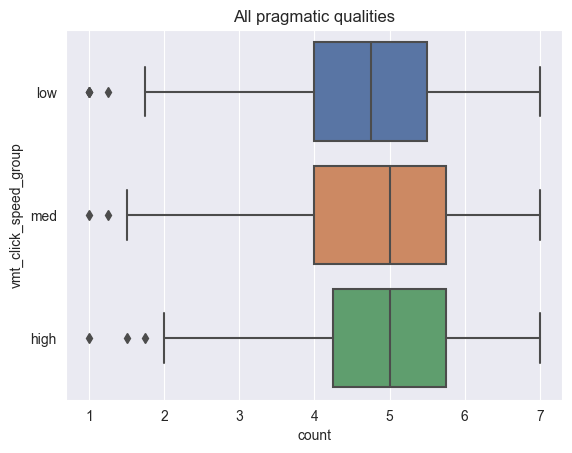

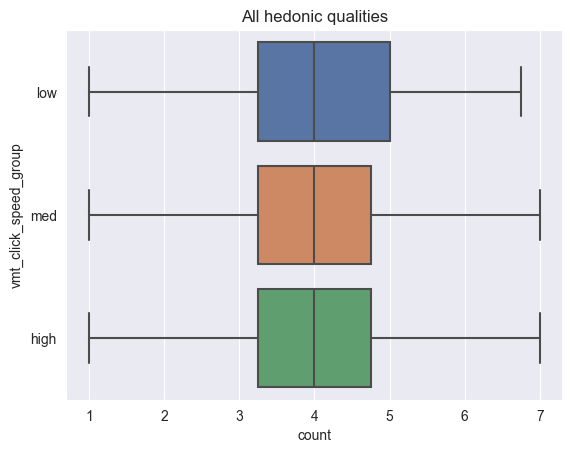

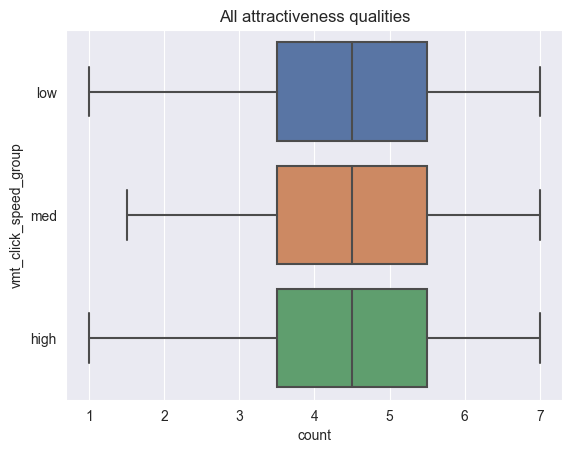

In [86]:
for column in ['PQ', 'HQ', 'ATT']:
    my_box_xy(data, column, 'vmt_click_speed_group', attrak[column], order=['low', 'med', 'high'])

In [87]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.f_oneway, data, column, 'vmt_click_speed_group', column + ' (' + attrak[column] + ')')

PQ (All pragmatic qualities)
 pvalue: 0.4311014830968046

HQ (All hedonic qualities)
 pvalue: 0.7670673153985861

ATT (All attractiveness qualities)
 pvalue: 0.881616367661635



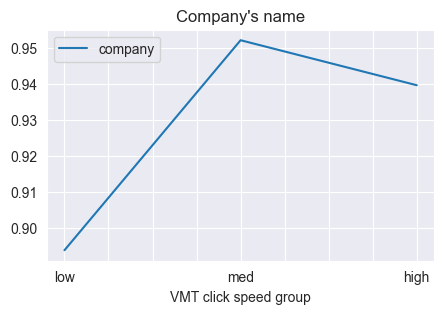

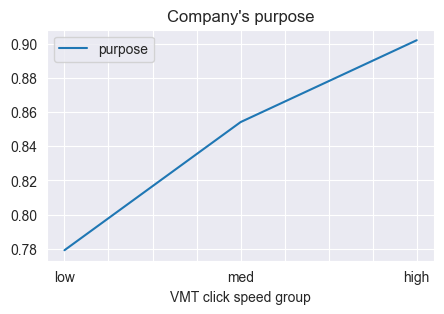

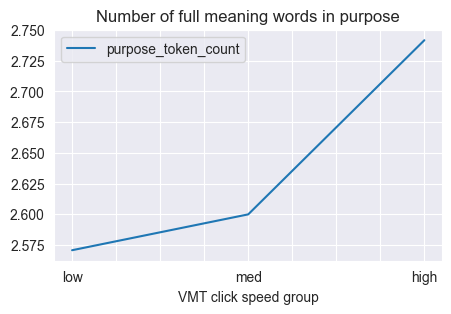

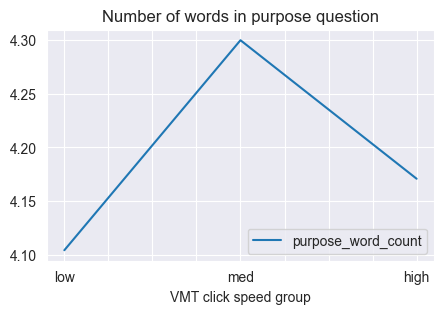

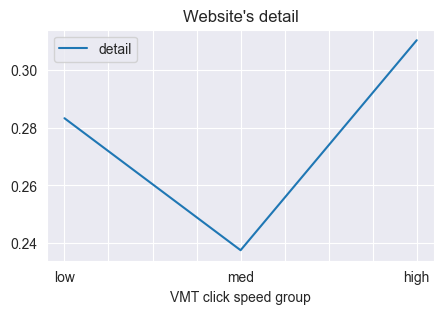

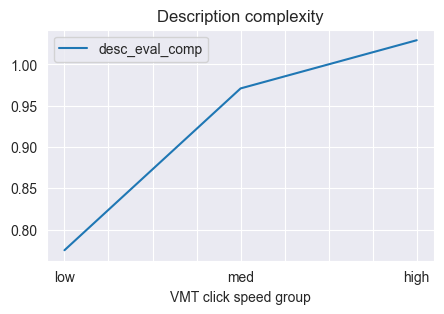

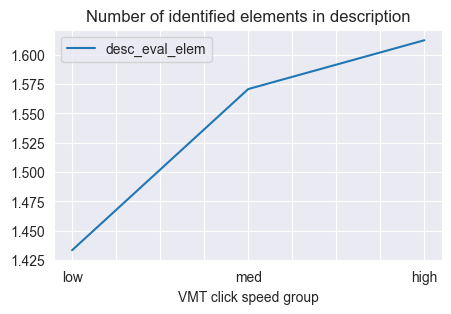

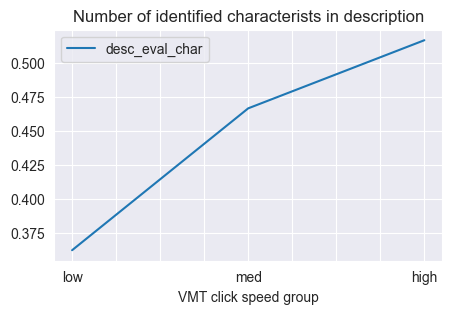

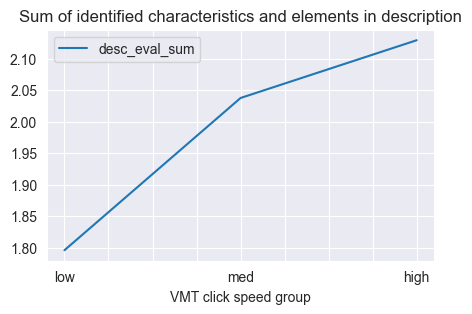

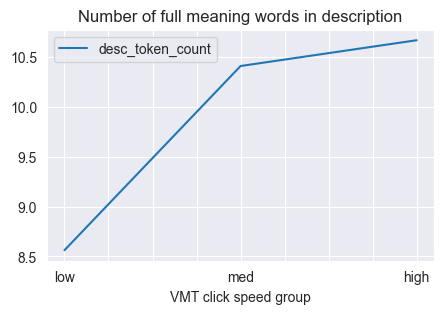

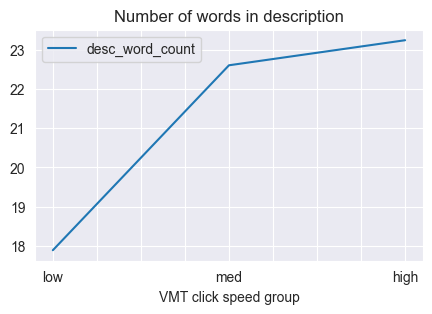

In [88]:
for column in open_text:
    my_mean_plot(data, column, 'vmt_click_speed_group', open_text[column], 'VMT click speed group', '', ['low', 'med', 'high'])

In [89]:
my_chi(fixed_data, 'company', 'vmt_click_speed_group', {1.0: [0.5]})

vmt_click_speed_group  high  low  med
company                              
0.0                      11   21    8
1.0                     223  219  232

----> pvalue: 0.027427186748770274

expected frequencies:
[[ 13.1092437   13.44537815  13.44537815]
 [220.8907563  226.55462185 226.55462185]]

Post-hoc testing:
('high', 'low')      0.13069926709434637                   0
('high', 'med')       0.4996073319629176                   0
('low', 'med')       0.06595565879469625                   0





In [90]:
my_chi(fixed_data, 'purpose', 'vmt_click_speed_group', {1.0: [0.5]})

vmt_click_speed_group  high  low  med
purpose                              
0.0                      14   45   27
1.0                     220  195  213

----> pvalue: 9.879491649811108e-05

expected frequencies:
[[ 28.18487395  28.90756303  28.90756303]
 [205.81512605 211.09243697 211.09243697]]

Post-hoc testing:
('high', 'low')     0.00014074924273560176                   1
('high', 'med')     0.030689012430054816                   1
('low', 'med')      0.030689012430054816                   1





In [91]:
my_chi(fixed_data, 'detail', 'vmt_click_speed_group', {1.0: [0.5]})

vmt_click_speed_group  high  low  med
detail                               
0.0                     158  169  180
1.0                      76   71   60

pvalue: 0.19393948357969013

expected frequencies:
[[166.15966387 170.42016807 170.42016807]
 [ 67.84033613  69.57983193  69.57983193]]



In [92]:
my_chi(fixed_data, 'desc_eval_elem', 'vmt_click_speed_group', {1: [2], 3: [4, 5]})

vmt_click_speed_group   high    low    med
desc_eval_elem                            
0                       43.0   54.0   53.0
1                      141.0  146.0  128.0
3                       50.0   40.0   59.0

pvalue: 0.18211347684233695

expected frequencies:
[[ 49.15966387  50.42016807  50.42016807]
 [136.00840336 139.49579832 139.49579832]
 [ 48.83193277  50.08403361  50.08403361]]



In [93]:
my_chi(fixed_data, 'desc_eval_char', 'vmt_click_speed_group', {2: [3]})

vmt_click_speed_group  high  low  med
desc_eval_char                       
0                       142  171  144
1                        68   52   82
2                        24   17   14

----> pvalue: 0.01196807783020615

expected frequencies:
[[149.77310924 153.61344538 153.61344538]
 [ 66.20168067  67.89915966  67.89915966]
 [ 18.02521008  18.48739496  18.48739496]]

Post-hoc testing:
('high', 'low')       0.0540674516065123                   0
('high', 'med')      0.05604138503276603                   0
('low', 'med')       0.02865595046470808                   1





In [94]:
my_chi(fixed_data, 'desc_eval_sum', 'vmt_click_speed_group', {1: [2], 3: [4, 5, 6]})

vmt_click_speed_group   high    low    med
desc_eval_sum                             
0                       27.0   36.0   29.0
1                      123.0  139.0  126.0
3                       84.0   65.0   85.0

pvalue: 0.22171730338169882

expected frequencies:
[[ 30.1512605   30.92436975  30.92436975]
 [127.15966387 130.42016807 130.42016807]
 [ 76.68907563  78.65546218  78.65546218]]



In [95]:
my_chi(fixed_data, 'desc_eval_comp', 'vmt_click_speed_group')

vmt_click_speed_group  high  low  med
desc_eval_comp                       
0                        76   95   86
1                        99  114   90
2                        40   21   49
3                        19   10   15

----> pvalue: 0.00461201641712471

expected frequencies:
[[ 84.22689076  86.38655462  86.38655462]
 [ 99.30252101 101.8487395  101.8487395 ]
 [ 36.05042017  36.97478992  36.97478992]
 [ 14.42016807  14.78991597  14.78991597]]

Post-hoc testing:
('high', 'low')     0.008149540783899054                   1
('high', 'med')      0.33712042731242264                   0
('low', 'med')      0.004372291751804612                   1





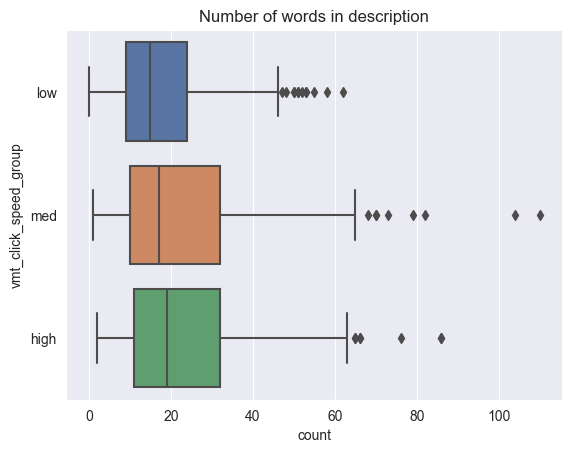

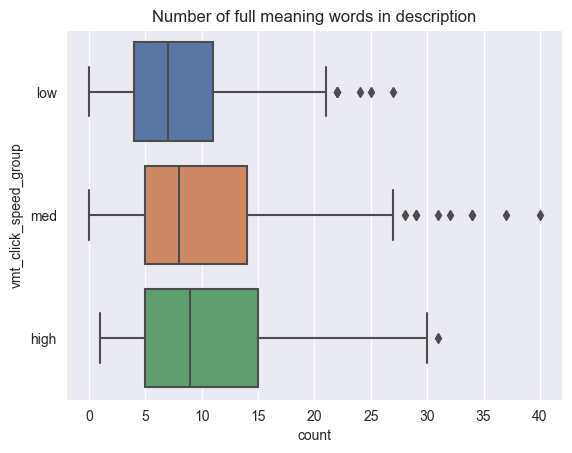

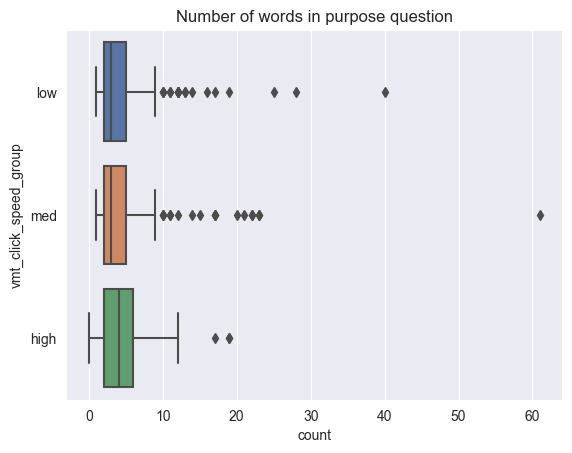

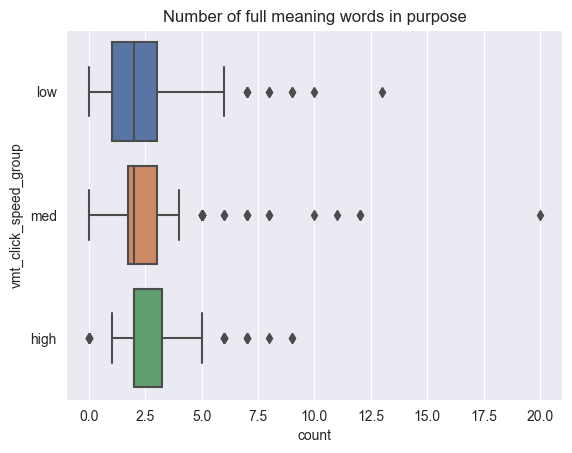

In [96]:
for column in ['desc_word_count', 'desc_token_count', 'purpose_word_count', 'purpose_token_count']:
    my_box_xy(data, column, 'vmt_click_speed_group', open_text[column], order=['low', 'med', 'high'])

In [97]:
for column in ['desc_word_count', 'desc_token_count']:
     my_test2(stats.kruskal, stats.mannwhitneyu, [
        data[data.vmt_click_speed_group == 'low'][column],
        data[data.vmt_click_speed_group == 'med'][column],
        data[data.vmt_click_speed_group == 'high'][column]
    ], column + ' (' + open_text[column] + ')', ['low', 'med', 'high'])

desc_word_count (Number of words in description)
low mean: 17.895833333333332
low std: 12.314293466148692
med mean: 22.6
med std: 18.305131091248224
high mean: 23.2375
high std: 16.899588083910736

----> pvalue: 0.005945921210717565

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.049549   0.00467852 0.36635889]
[ True  True False]


desc_token_count (Number of full meaning words in description)
low mean: 8.5625
low std: 5.310864564906381
med mean: 10.408333333333333
med std: 7.326224841782912
high mean: 10.666666666666666
high std: 6.650049024053522

----> pvalue: 0.005131436855981419

Post-hoc testing:
[('low', 'med'), ('low', 'high'), ('med', 'high')]
[0.04115544 0.00430205 0.37561291]
[ True  True False]




In [98]:
for column in ['desc_word_count_group', 'desc_token_count_group']:
    my_chi(fixed_data, column, 'vmt_click_speed_group')

vmt_click_speed_group  high  low  med
desc_word_count_group                
high                     89   61   84
low                      71   85   82
med                      74   94   74

----> pvalue: 0.03595308413802079

expected frequencies:
[[76.68907563 78.65546218 78.65546218]
 [78.         80.         80.        ]
 [79.31092437 81.34453782 81.34453782]]

Post-hoc testing:
('high', 'low')     0.037488801410380544                   1
('high', 'med')       0.6208375032143596                   0
('low', 'med')      0.050155769610713906                   0



vmt_click_speed_group   high  low  med
desc_token_count_group                
high                      76   48   78
low                       65   75   70
med                       93  117   92

----> pvalue: 0.0118122611106702

expected frequencies:
[[ 66.20168067  67.89915966  67.89915966]
 [ 68.82352941  70.58823529  70.58823529]
 [ 98.97478992 101.51260504 101.51260504]]

Post-hoc testing:
('high', 'low')     0.017449595

**Completion times**

In [99]:
data[['time', 'vmt_levels_group']].groupby(['vmt_levels_group']).mean()

time
vmt_levels_group            
high              154.505556
low               140.005747
med               123.834344

In [100]:
data[['time', 'pst_levels_correct_group']].groupby(['pst_levels_correct_group']).mean()

time
pst_levels_correct_group            
high                      120.220810
low                       147.777778
med                       137.173469